In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import shap
from shap.maskers import Independent

In [2]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap,PauliFeatureMap , RealAmplitudes, EfficientSU2
from qiskit_algorithms.utils import algorithm_globals
import qiskit_algorithms.optimizers as op
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC

#### <center><h1><b>Data Cleaning</b></h1></center>

In [ ]:
df1 = pd.read_excel('ZP-Fe_vs_AgNP_and_CoNP_vs_AgNP_110325_train.xls', sheet_name = 'Fe NP')

In [ ]:
df2 = pd.read_excel('ZP-Fe_vs_AgNP_and_CoNP_vs_AgNP_110325_train.xls', sheet_name = 'Co NP')

In [ ]:
df3 = pd.read_excel('ZP-Fe_vs_AgNP_and_CoNP_vs_AgNP_110325_train.xls', sheet_name = 'AgNP')

In [6]:
df1 = df1.iloc[1:]
df2 = df2.iloc[1:]
df3 = df3.iloc[1:]

In [7]:
df1 = df1[['Sample Name', 'ZP', 'Cond', 'Mean Count Rate']]
df2 = df2[['Sample Name', 'ZP', 'Cond', 'Mean Count Rate']]
df3 = df3[['Sample Name', 'ZP', 'Cond', 'Mean Count Rate']]

In [8]:
def redefine_sample_name(sample):
    if 'fe ' in sample:
        return 0
    elif 'Co ' in sample:
        return 2
    elif 'Ag NP ' in sample:
        return 3

In [9]:
df1.isnull().sum()

Sample Name        0
ZP                 0
Cond               0
Mean Count Rate    0
dtype: int64

In [10]:
df2.isnull().sum()

Sample Name        0
ZP                 0
Cond               0
Mean Count Rate    0
dtype: int64

In [11]:
df3.isnull().sum()

Sample Name        0
ZP                 0
Cond               0
Mean Count Rate    0
dtype: int64

In [ ]:
df4 = pd.read_excel('ZP-Fe_vs_AgNP_and_CoNP_vs_AgNP_110325_test.xls', sheet_name = 'Fe NP')

In [ ]:
df5 = pd.read_excel('ZP-Fe_vs_AgNP_and_CoNP_vs_AgNP_110325_test.xls', sheet_name = 'Co NP')

In [ ]:
df6 = pd.read_excel('ZP-Fe_vs_AgNP_and_CoNP_vs_AgNP_110325_test.xls', sheet_name = 'AgNP')

In [15]:
df4 = df4.iloc[1:]
df5 = df5.iloc[1:]
df6 = df6.iloc[1:]

In [16]:
df4 = df4[['Sample Name', 'ZP', 'Cond', 'Mean Count Rate']]
df5 = df5[['Sample Name', 'ZP', 'Cond', 'Mean Count Rate']]
df6 = df6[['Sample Name', 'ZP', 'Cond', 'Mean Count Rate']]

In [17]:
df4.isnull().sum()

Sample Name        0
ZP                 0
Cond               0
Mean Count Rate    0
dtype: int64

In [18]:
df5.isnull().sum()

Sample Name        0
ZP                 0
Cond               0
Mean Count Rate    0
dtype: int64

In [19]:
df6.isnull().sum()

Sample Name        0
ZP                 0
Cond               0
Mean Count Rate    0
dtype: int64

In [20]:
df1['Sample Name'] = df1['Sample Name'].apply(redefine_sample_name)
df2['Sample Name'] = df2['Sample Name'].apply(redefine_sample_name)
df3['Sample Name'] = df3['Sample Name'].apply(redefine_sample_name)
df4['Sample Name'] = df4['Sample Name'].apply(redefine_sample_name)
df5['Sample Name'] = df5['Sample Name'].apply(redefine_sample_name)
df6['Sample Name'] = df6['Sample Name'].apply(redefine_sample_name)

#### Training Set

In [21]:
dataset1 = pd.concat([df1, df3], axis = 0)
dataset2 = pd.concat([df2, df3], axis = 0)

#### Test Set

In [22]:
dataset3 = pd.concat([df4, df6], axis = 0)
dataset4 = pd.concat([df5, df6], axis = 0)

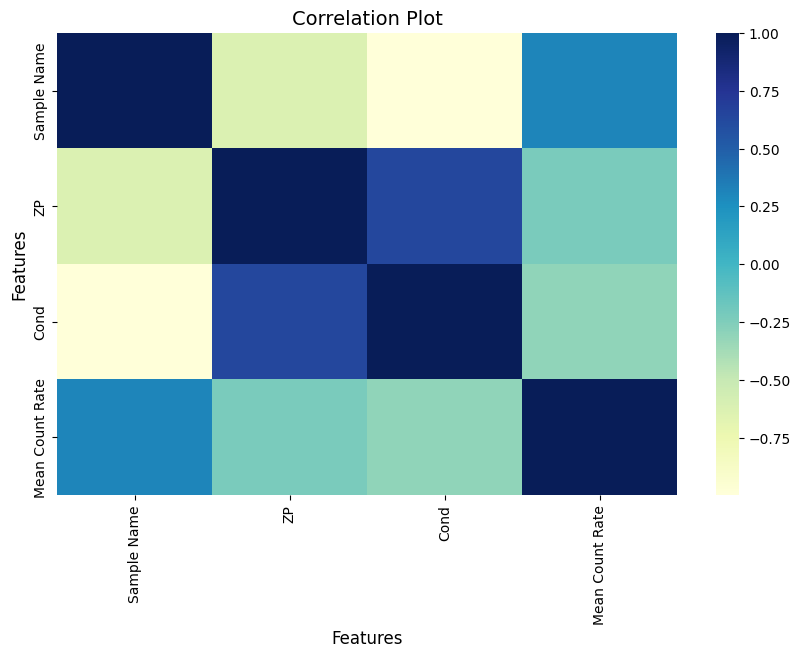

In [23]:
#========================Creating correlation matrix for the Glioma datastet==================================
columns = ['Sample Name', 'ZP', 'Cond', 'Mean Count Rate']

correlation_matrix = dataset1[columns].corr()
# Create a correlation plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(correlation_matrix, cmap='YlGnBu')
# Add plot title and adjust font size
plt.title('Correlation Plot', fontsize=14)
# Set the font size of the axis labels
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
# Show the plot
plt.show()
#===============================================================================================================

In [24]:
#================Method to evaluate classical ML models==============
def evaluate_model(model, train_set, X_train, y_train, X_test, y_test):
    acc_ls = []
    pred_ls = []
    train_data = []
    pred_proba_ls = []
    for elm in train_set:
        clf = copy.deepcopy(model)
        X_t, dummy_x, y_t, dummy_y = train_test_split(copy.copy(X_train), y_train, train_size=elm, random_state=algorithm_globals.random_seed)
        # Fitting the classifier to the training data
        clf.fit(X_t, y_t)
        train_data.append(y_t)
        # Making predictions on the testing data
        start = time.time()
        y_pred = clf.predict(X_test)
        end = time.time()
        y_pred_proba = clf.predict_proba(X_test)
        pred_ls.append(y_pred)
        pred_proba_ls.append(y_pred_proba)
        # Evaluating the accuracy of the model
        accuracy = accuracy_score(y_test, y_pred)
        acc_ls.append(accuracy)
        execution_time = end-start
        print(f'Accuracy score({clf.__class__.__name__} model): {accuracy:.6f} with {elm*100}% training records')
        print(f'Execution Time({clf.__class__.__name__} model): {execution_time:.6f} seconds with {elm*100}% training records')
        print()
    return acc_ls, pred_ls, train_data, pred_proba_ls

In [25]:
#=====================Method to show ROC Curve of the model based on different training set===========================
def evaluate_ROC(train_set, y_test, pred_ls):
    for i in range(len(train_set)):
        # Compute the ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, pred_ls[i])
        roc_auc = auc(fpr, tpr)
        # Compute the confidence interval
        std_err = np.sqrt(np.divide(tpr * (1 - tpr), y_test.size, where=(y_test.size != 0)) * (fpr + tpr))
        # Compute the confidence interval with explicit broadcasting
        upper_bound = tpr + std_err * 1.96
        lower_bound = tpr - std_err * 1.96
        # Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='b', label='AUC = %0.2f' % roc_auc)
        plt.fill_between(fpr, lower_bound, upper_bound, color='lightblue', alpha=0.5,label = '\n95%% CI: [%0.2f, %0.2f]' % (lower_bound[1], upper_bound[1]))
        plt.plot([0, 1], [0, 1], color='r', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'ROC Curve (95% CI), {train_set[i]*100}% Training Data')
        plt.legend(loc="lower right")
        plt.show()

In [26]:
#=========================Method to show Confusion Matrix on different Training Set==============================
def evaluate_con_mat(train_set, y_test, pred_ls):
    for i in range(len(train_set)):
        # Calculate the confusion matrix
        cm = confusion_matrix(y_test, pred_ls[i])
        # Create a heatmap of the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix ({train_set[i]*100}% Training Data)')
        plt.show()

In [27]:
train_set = [0.70, 0.50, 0.1, 0.01]

In [28]:
training_sample = []
for i in range(len(train_set)):
    training_sample.append(train_set[i] * 100)

In [29]:
algorithm_globals.random_seed = 123

# <center><h1><b>Task 1 (FeNP vs AgNP)</b></h1></center>

In [30]:
#==================Predictor Variables=====================================
X_train = dataset1[['ZP', 'Cond', 'Mean Count Rate']]
X_test = dataset3[['ZP', 'Cond', 'Mean Count Rate']]
#===================Output Variable========================================
y_train = dataset1['Sample Name'].apply(lambda x: 1 if x == 3 else 0)
y_test = dataset3['Sample Name'].apply(lambda x: 1 if x == 3 else 0)

## Logistic Regression
### Logistic Regression without hyperparameter tuning (FeNP vs AgNP)

In [31]:
#=====================Logistic Regression Model with different training sets================
eval_mod=evaluate_model(LogisticRegression(solver='lbfgs', max_iter=1000), train_set, X_train, y_train, X_test, y_test)

Accuracy score(LogisticRegression model): 1.000000 with 70.0% training records
Execution Time(LogisticRegression model): 0.002290 seconds with 70.0% training records

Accuracy score(LogisticRegression model): 1.000000 with 50.0% training records
Execution Time(LogisticRegression model): 0.001823 seconds with 50.0% training records

Accuracy score(LogisticRegression model): 0.980000 with 10.0% training records
Execution Time(LogisticRegression model): 0.001583 seconds with 10.0% training records

Accuracy score(LogisticRegression model): 0.980000 with 1.0% training records
Execution Time(LogisticRegression model): 0.001459 seconds with 1.0% training records



In [32]:
#===============================Hyperparameter Tuning================================
clf_LR = LogisticRegression(solver = 'lbfgs', max_iter=1000)
param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l2'], 'solver': ['newton-cg','lbfgs' ,'liblinear', 'saga']}
grid_search = GridSearchCV(clf_LR, param_grid, cv=10, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


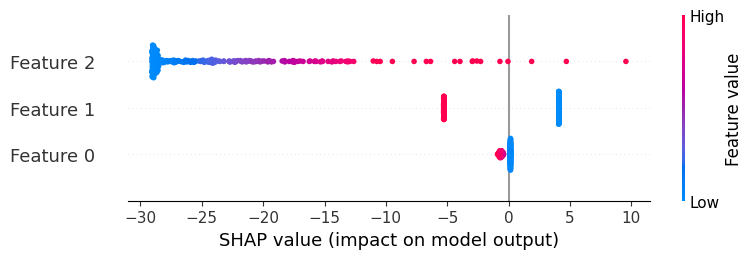

In [33]:
best_model = grid_search.best_estimator_
# Use SHAP's LinearExplainer with the best model
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)
    X_t = np.array(X_test, dtype=float)
    shap_values = np.array(shap_values, dtype=float)
shap.summary_plot(shap_values,X_t)

### Logistic Regression with hyperparameter tuning

In [34]:
#==============================Logistic Regression Model with Hyperparameter Tuning===========================
acc_LR, pred_LR, train_data, pred_proba_LR = evaluate_model(LogisticRegression(solver = best_params['solver'], penalty=best_params['penalty'], C = best_params['C']), train_set, X_train, y_train, X_test, y_test)

Accuracy score(LogisticRegression model): 1.000000 with 70.0% training records
Execution Time(LogisticRegression model): 0.001211 seconds with 70.0% training records

Accuracy score(LogisticRegression model): 1.000000 with 50.0% training records
Execution Time(LogisticRegression model): 0.001168 seconds with 50.0% training records

Accuracy score(LogisticRegression model): 0.980000 with 10.0% training records
Execution Time(LogisticRegression model): 0.001208 seconds with 10.0% training records

Accuracy score(LogisticRegression model): 0.983333 with 1.0% training records
Execution Time(LogisticRegression model): 0.001194 seconds with 1.0% training records



### Learning Curve for Logistic Regression (FeNP vs AgNP)

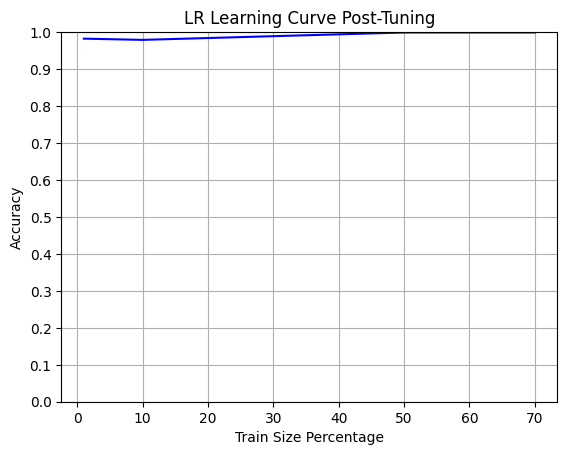

In [35]:
#===============================Learning Curve for LR===========================================
plt.plot(training_sample,acc_LR, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for Logistic Regression (FeNP vs AgNP)

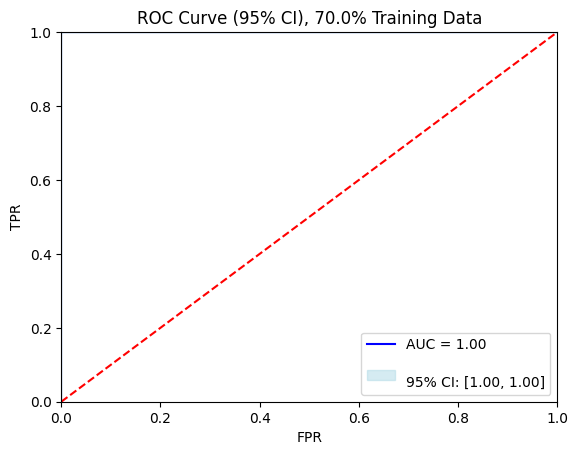

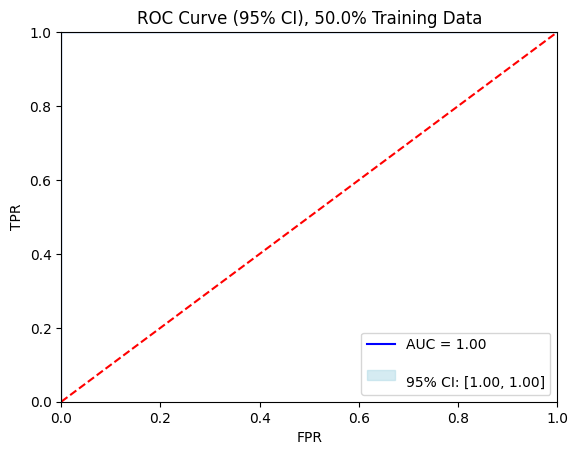

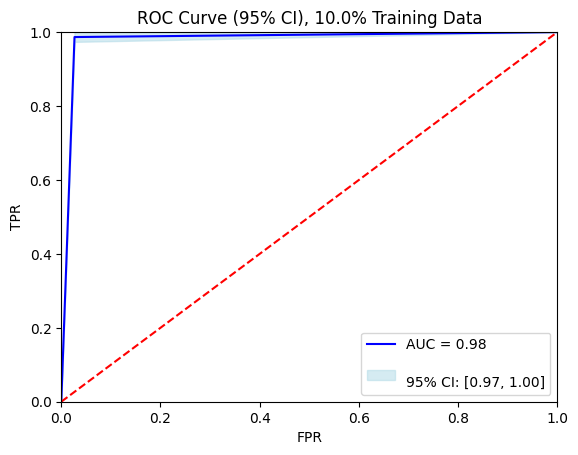

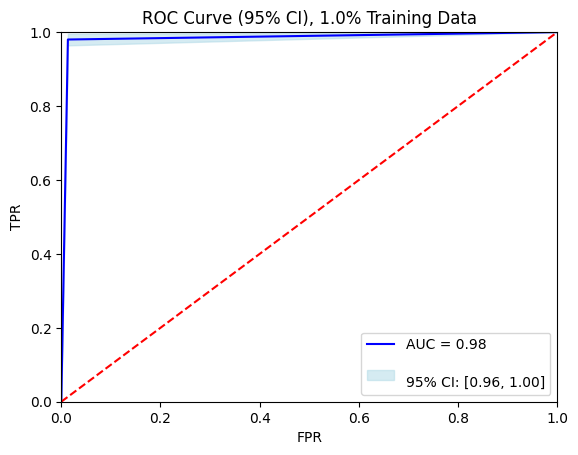

In [36]:
evaluate_ROC(train_set, y_test, pred_LR)

### Confusion Matrix for Logistic Regression (FeNP vs AgNP)

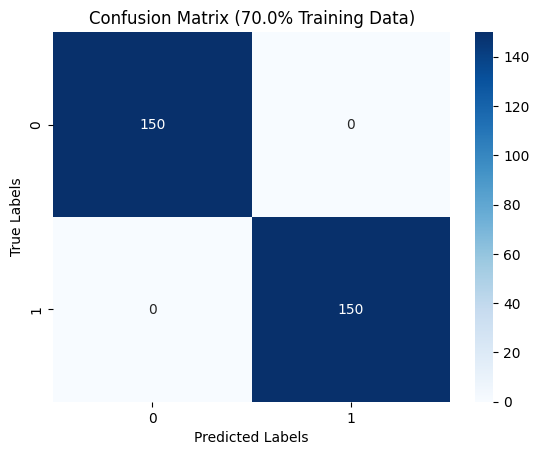

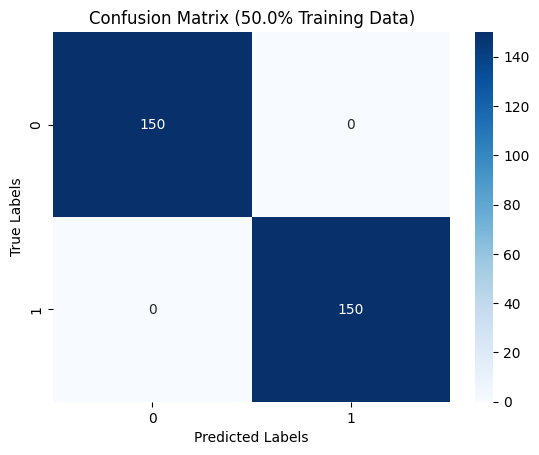

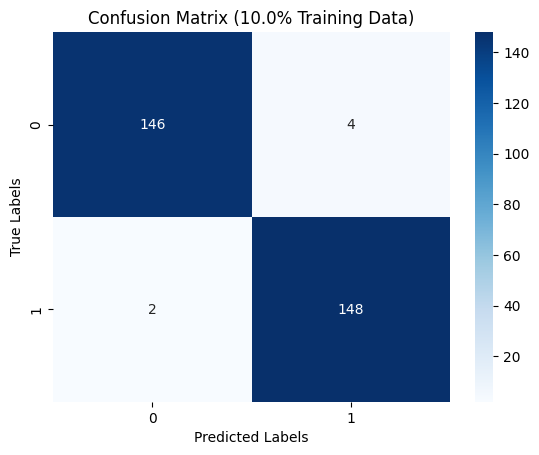

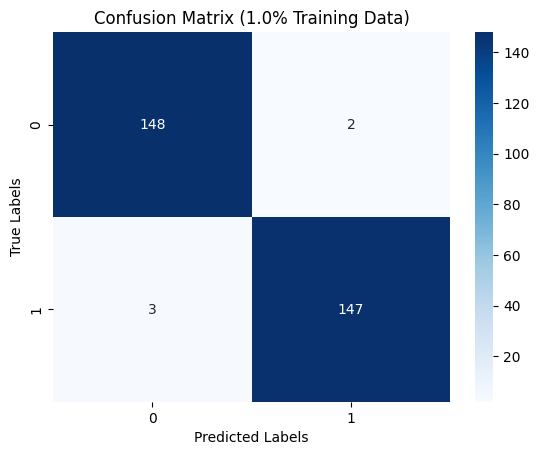

In [37]:
evaluate_con_mat(train_set, y_test, pred_LR)

In [38]:
del acc_LR, pred_LR, train_data, pred_proba_LR, best_params, clf_LR

## Decision Tree

### Decision Tree without hyperparameter tuning (FeNP vs AgNP)

In [39]:
eval_mod=evaluate_model(DecisionTreeClassifier(max_depth = 10,  min_samples_split = 10), train_set, X_train, y_train, X_test, y_test)

Accuracy score(DecisionTreeClassifier model): 1.000000 with 70.0% training records
Execution Time(DecisionTreeClassifier model): 0.002432 seconds with 70.0% training records

Accuracy score(DecisionTreeClassifier model): 1.000000 with 50.0% training records
Execution Time(DecisionTreeClassifier model): 0.002058 seconds with 50.0% training records

Accuracy score(DecisionTreeClassifier model): 1.000000 with 10.0% training records
Execution Time(DecisionTreeClassifier model): 0.002028 seconds with 10.0% training records

Accuracy score(DecisionTreeClassifier model): 0.500000 with 1.0% training records
Execution Time(DecisionTreeClassifier model): 0.001909 seconds with 1.0% training records



In [40]:
#==============================Hyperparameter  Tuning======================================
clf_DT = DecisionTreeClassifier(max_depth = 10,  min_samples_split = 10)
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(estimator=clf_DT, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': None, 'min_samples_split': 2}


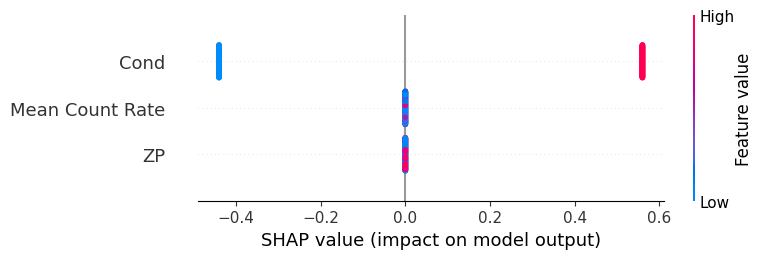

In [41]:
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
explainer_rf = shap.Explainer(grid_search.best_estimator_, X_train_norm)
shap_values_rf = explainer_rf(X_test_norm)
shap_values_class_1 = shap_values_rf.values[..., 1]
shap.summary_plot(shap_values_class_1, X_test_norm)

### Decision Tree with hyperparameter tuning (FeNP vs AgNP)

In [42]:
#==============================Random Forest Model with Hyperparameter Tuning===========================
acc_DT, pred_DT, train_data, pred_proba_DT = evaluate_model(grid_search.best_estimator_, train_set, X_train, y_train, X_test, y_test)

Accuracy score(DecisionTreeClassifier model): 1.000000 with 70.0% training records
Execution Time(DecisionTreeClassifier model): 0.002373 seconds with 70.0% training records

Accuracy score(DecisionTreeClassifier model): 1.000000 with 50.0% training records
Execution Time(DecisionTreeClassifier model): 0.001974 seconds with 50.0% training records

Accuracy score(DecisionTreeClassifier model): 0.980000 with 10.0% training records
Execution Time(DecisionTreeClassifier model): 0.001865 seconds with 10.0% training records

Accuracy score(DecisionTreeClassifier model): 1.000000 with 1.0% training records
Execution Time(DecisionTreeClassifier model): 0.001797 seconds with 1.0% training records



### Learning Curve for Decision Tree (FeNP vs AgNP)

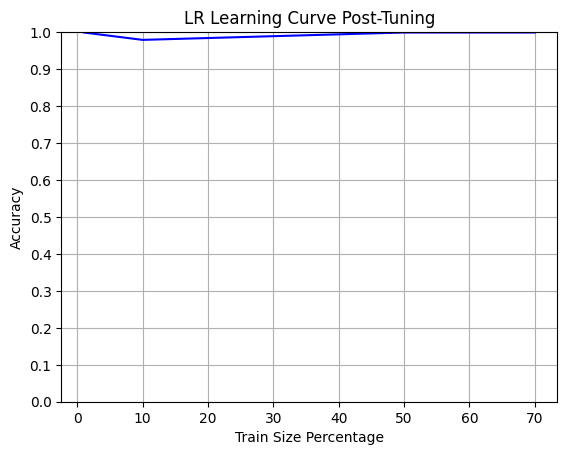

In [43]:
#===============================Learning Curve for Random Forest===========================================
plt.plot(training_sample,acc_DT, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for Decision Tree (FeNP vs AgNP)

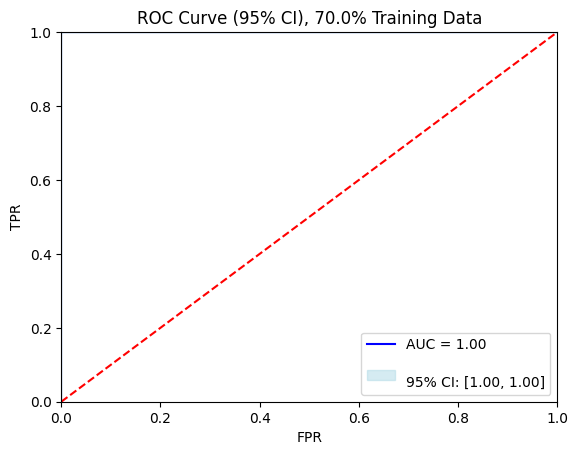

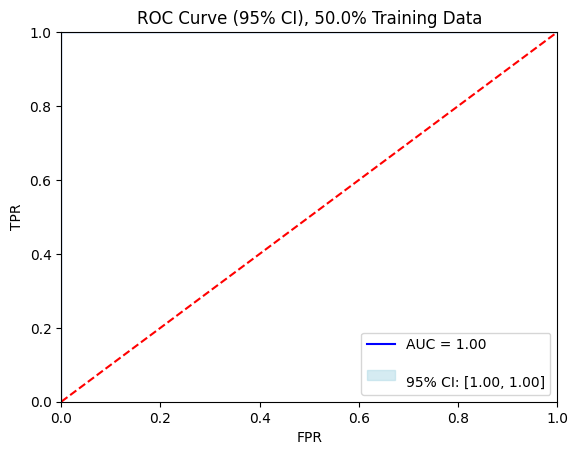

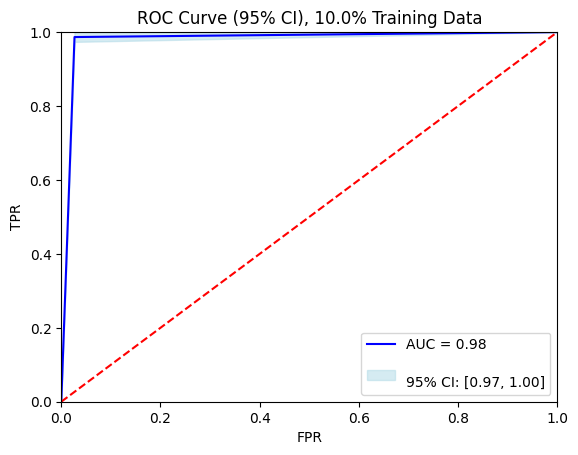

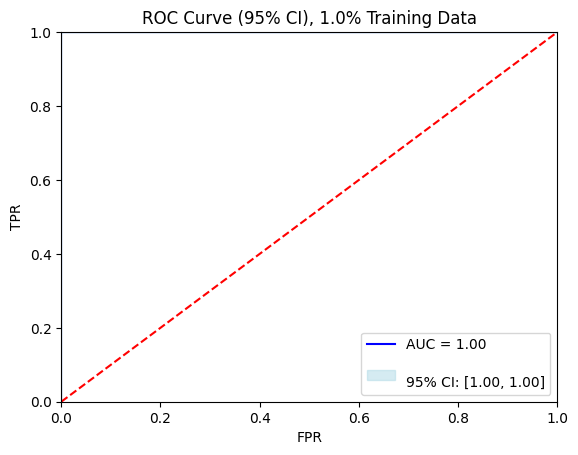

In [44]:
evaluate_ROC(train_set, y_test, pred_DT)

### Confusion Matrix for Decision Tree (FeNP vs AgNP)

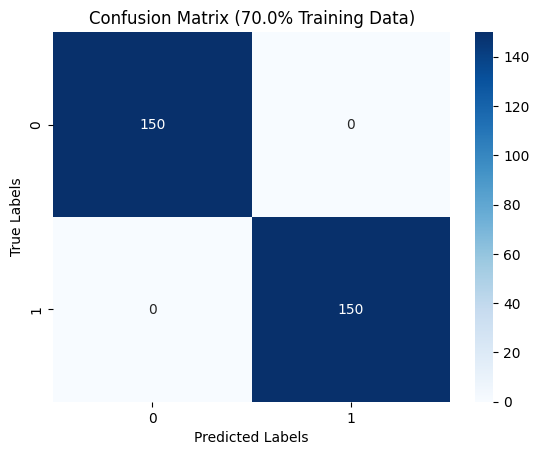

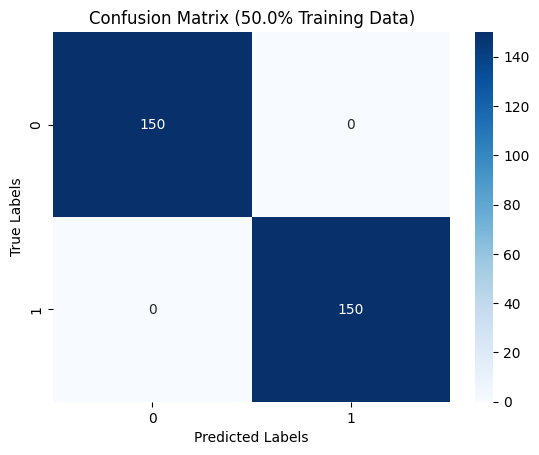

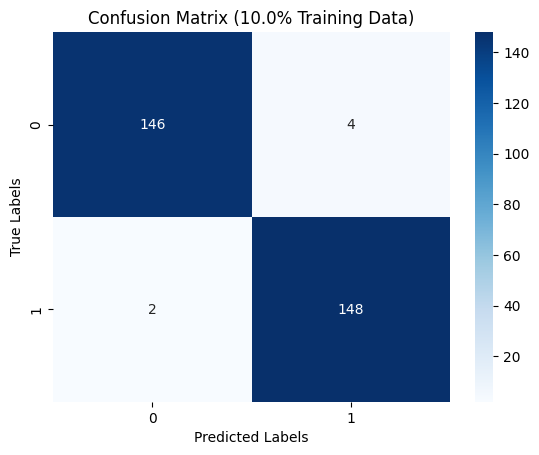

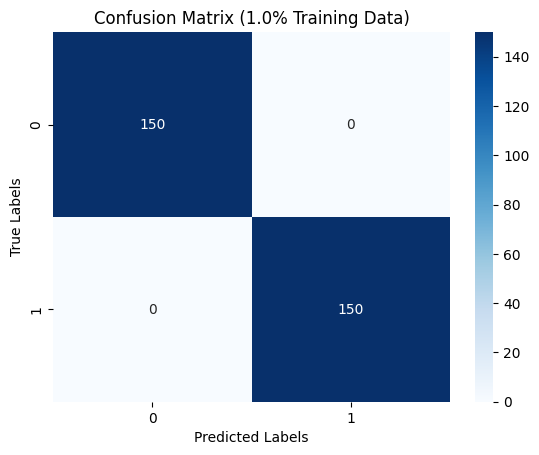

In [45]:
evaluate_con_mat(train_set, y_test, pred_DT)

In [46]:
del  acc_DT, pred_DT, train_data, pred_proba_DT, best_params, clf_DT

## Support Vector Classifier

### Support Vector Classifier  without hyperparameter tuning (FeNP vs AgNP)

In [47]:
eval_mod=evaluate_model(SVC(kernel='sigmoid', probability=True, C = 100, gamma='auto'), train_set, X_train, y_train, X_test, y_test)

Accuracy score(SVC model): 0.500000 with 70.0% training records
Execution Time(SVC model): 0.005312 seconds with 70.0% training records

Accuracy score(SVC model): 0.500000 with 50.0% training records
Execution Time(SVC model): 0.003762 seconds with 50.0% training records

Accuracy score(SVC model): 0.500000 with 10.0% training records
Execution Time(SVC model): 0.001811 seconds with 10.0% training records

Accuracy score(SVC model): 0.500000 with 1.0% training records
Execution Time(SVC model): 0.001328 seconds with 1.0% training records



In [48]:
#==========================Hyperparameter Tuning==========================
clf_SVM = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1]
}
grid_search = GridSearchCV(estimator=clf_SVM, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

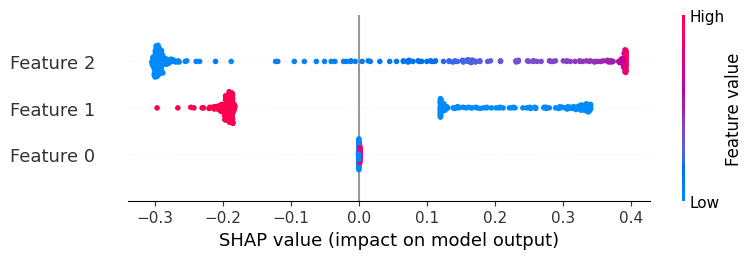

In [49]:
best_model = grid_search.best_estimator_
explainer_svc = shap.KernelExplainer(best_model.predict_proba, X_train)
# shap_values = np.array(X_t, dtype=float)
shap_values_svc = explainer_svc(X_test)
shap_values_svc_class_1 = shap_values_svc.values[..., 1]
shap.summary_plot(shap_values_svc_class_1, X_t)

### Support Vector Classifier with hyperparameter tuning (FeNP vs AgNP)

In [50]:
acc_SVC, pred_SVC, train_data, pred_proba_SVC=evaluate_model(grid_search.best_estimator_, train_set, X_train, y_train, X_test, y_test)

Accuracy score(SVC model): 1.000000 with 70.0% training records
Execution Time(SVC model): 0.001312 seconds with 70.0% training records

Accuracy score(SVC model): 1.000000 with 50.0% training records
Execution Time(SVC model): 0.001304 seconds with 50.0% training records

Accuracy score(SVC model): 0.980000 with 10.0% training records
Execution Time(SVC model): 0.001288 seconds with 10.0% training records

Accuracy score(SVC model): 0.980000 with 1.0% training records
Execution Time(SVC model): 0.001290 seconds with 1.0% training records



### Learning Curve for Support Vector Classifier (FeNP vs AgNP)

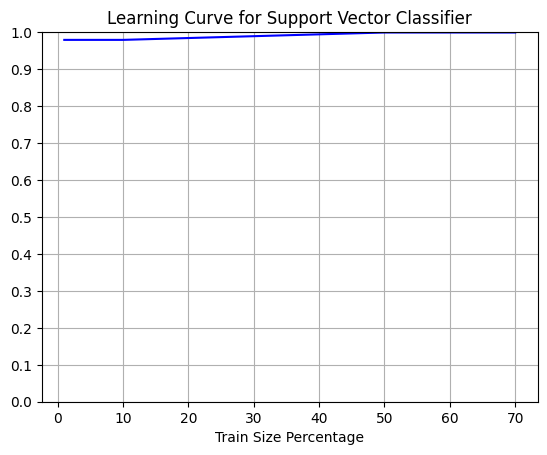

In [51]:
#===============================Learning Curve for SVC===========================================
plt.plot(training_sample,acc_SVC, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for Support Vector Classifier')
plt.show()

### ROC Curve for Support Vector Classifier (FeNP vs AgNP)

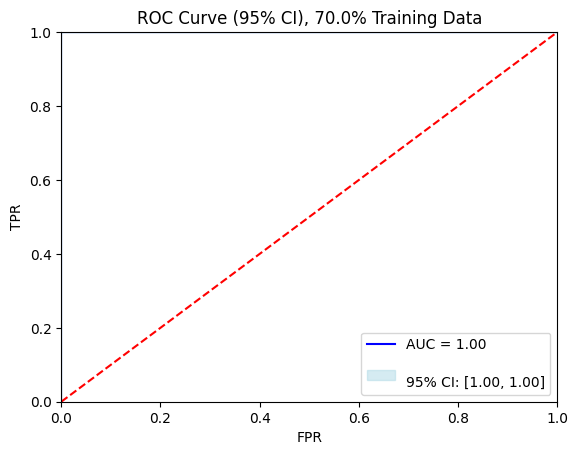

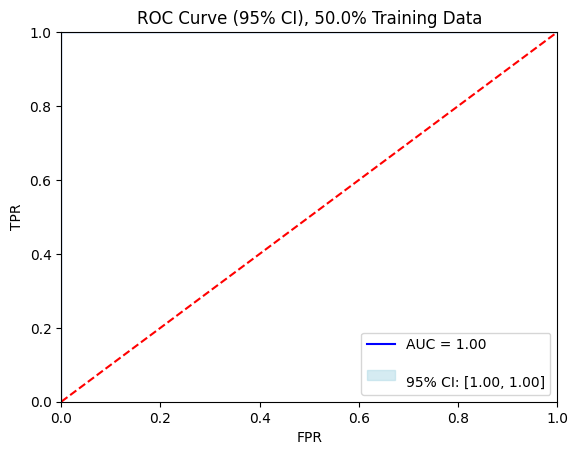

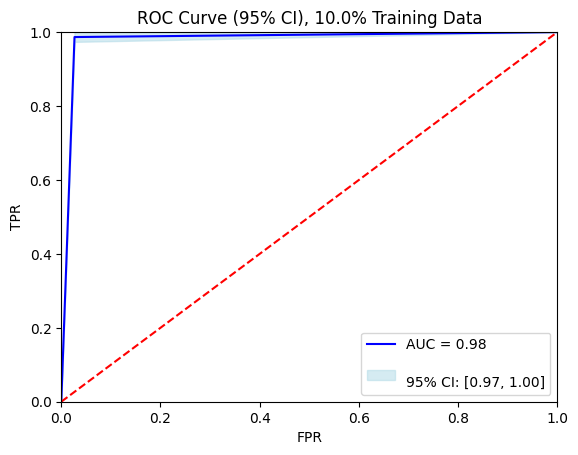

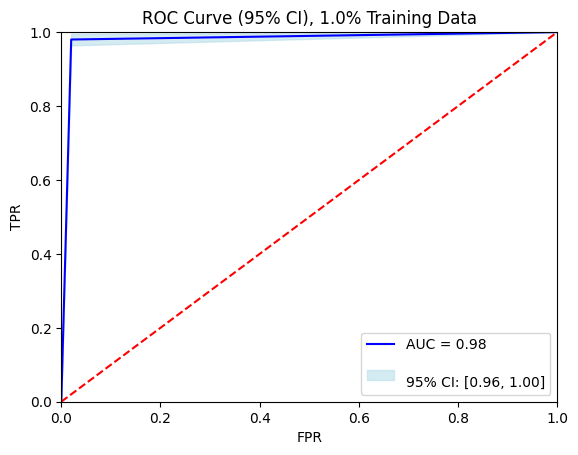

In [52]:
evaluate_ROC(train_set, y_test, pred_SVC)

### Confusion Matrix for Support Vector Classifier (FeNP vs AgNP)

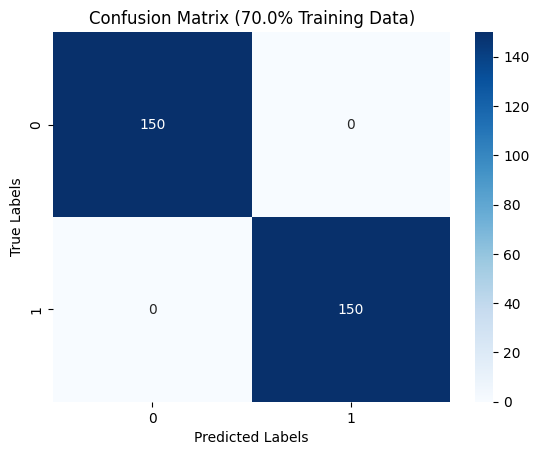

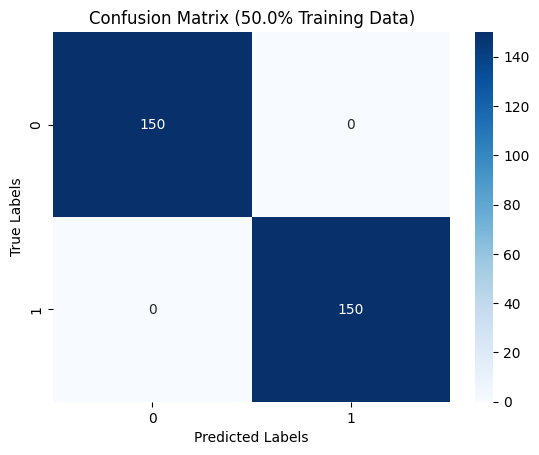

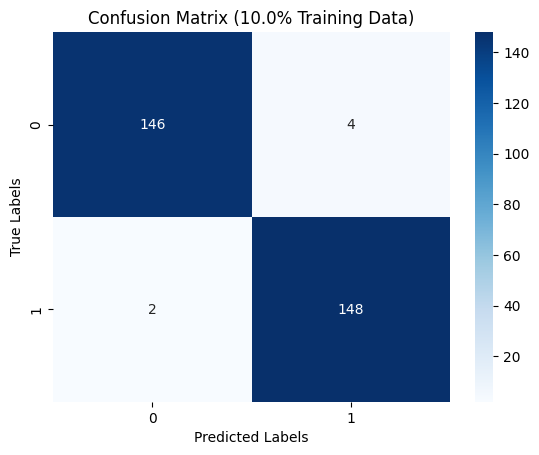

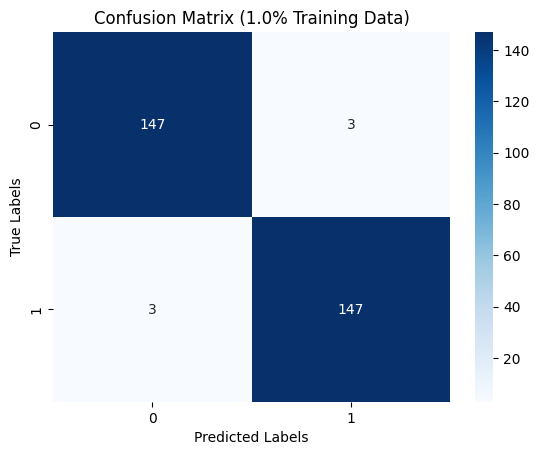

In [53]:
evaluate_con_mat(train_set, y_test, pred_SVC)

In [54]:
del acc_SVC, pred_SVC, train_data, pred_proba_SVC, best_params, clf_SVM

## KNN Classifier

In [55]:
eval_mod=evaluate_model(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean'), train_set, X_train, y_train, X_test, y_test)

Accuracy score(KNeighborsClassifier model): 0.986667 with 70.0% training records
Execution Time(KNeighborsClassifier model): 0.005053 seconds with 70.0% training records

Accuracy score(KNeighborsClassifier model): 0.983333 with 50.0% training records
Execution Time(KNeighborsClassifier model): 0.004007 seconds with 50.0% training records

Accuracy score(KNeighborsClassifier model): 0.980000 with 10.0% training records
Execution Time(KNeighborsClassifier model): 0.003444 seconds with 10.0% training records

Accuracy score(KNeighborsClassifier model): 0.860000 with 1.0% training records
Execution Time(KNeighborsClassifier model): 0.201216 seconds with 1.0% training records



In [56]:
#===============================Hyperparameter Tuning================================
clf_KNN = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(clf_KNN, param_grid, cv=10, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

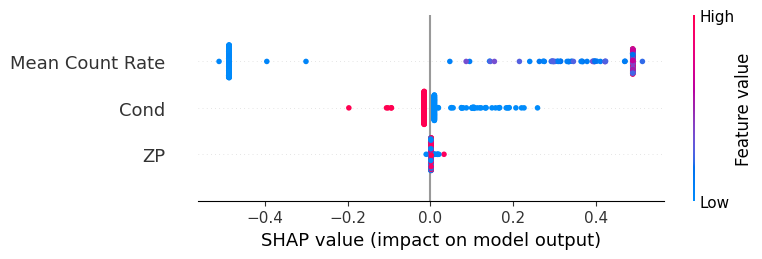

In [57]:
best_model = grid_search.best_estimator_
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train)
    shap_values = explainer.shap_values(X_test)
    X_t = np.array(X_test, dtype=float)
    shap_values = np.array(shap_values, dtype=float)

shap.summary_plot(shap_values[:, :, 1], X_t, feature_names=X_train.columns if hasattr(X_train, 'columns') else None)

### KNN Classifier with hyperparameter tuning

In [58]:
#==============================KNN Model with Hyperparameter Tuning===========================
acc_KNN, pred_KNN, train_data, pred_proba_KNN = evaluate_model(KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean'), train_set, X_train, y_train, X_test, y_test)

Accuracy score(KNeighborsClassifier model): 0.983333 with 70.0% training records
Execution Time(KNeighborsClassifier model): 0.002416 seconds with 70.0% training records

Accuracy score(KNeighborsClassifier model): 0.986667 with 50.0% training records
Execution Time(KNeighborsClassifier model): 0.002013 seconds with 50.0% training records

Accuracy score(KNeighborsClassifier model): 0.980000 with 10.0% training records
Execution Time(KNeighborsClassifier model): 0.001852 seconds with 10.0% training records

Accuracy score(KNeighborsClassifier model): 0.910000 with 1.0% training records
Execution Time(KNeighborsClassifier model): 0.002137 seconds with 1.0% training records



### Learning Curve for KNN (FeNP vs AgNP)

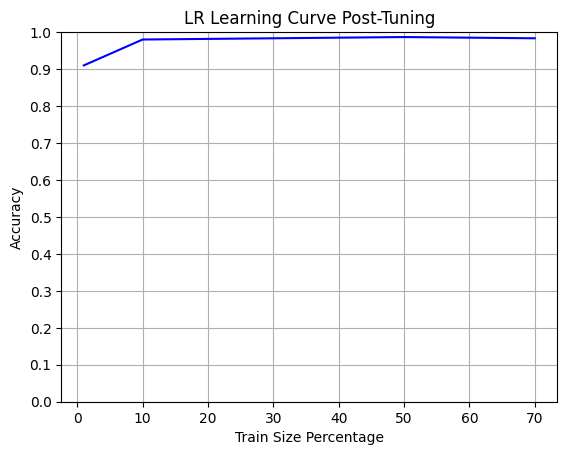

In [59]:
#===============================Learning Curve for LR===========================================
plt.plot(training_sample,acc_KNN, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for KNN (FeNP vs AgNP)

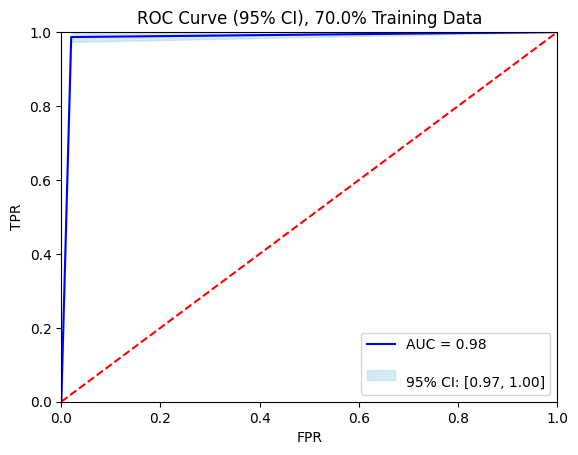

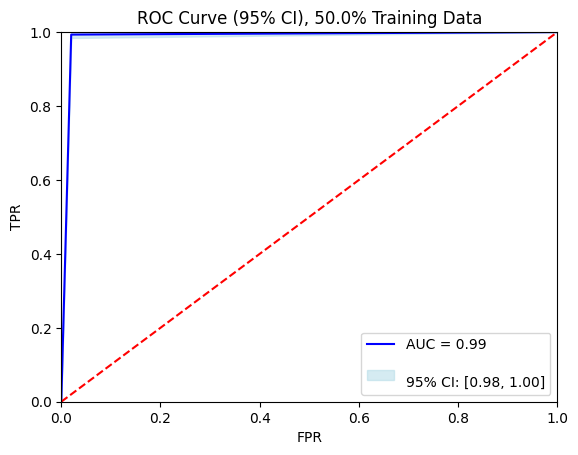

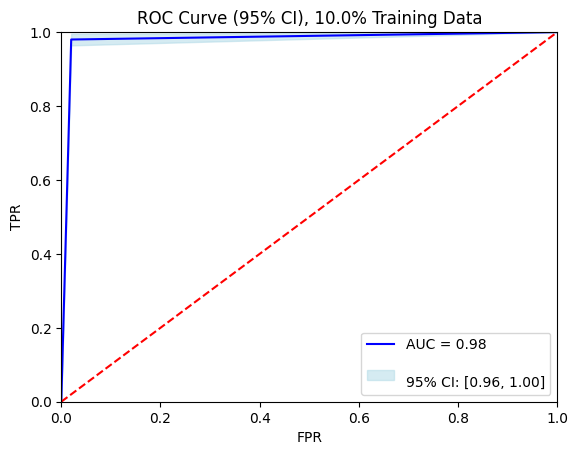

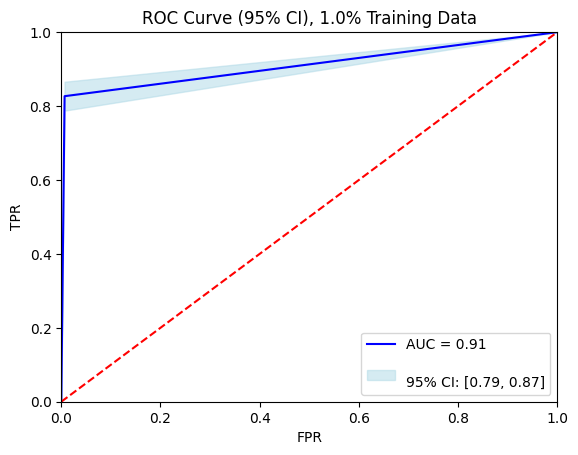

In [60]:
evaluate_ROC(train_set, y_test, pred_KNN)

### Confusion Matrix for KNN (FeNP vs AgNP)

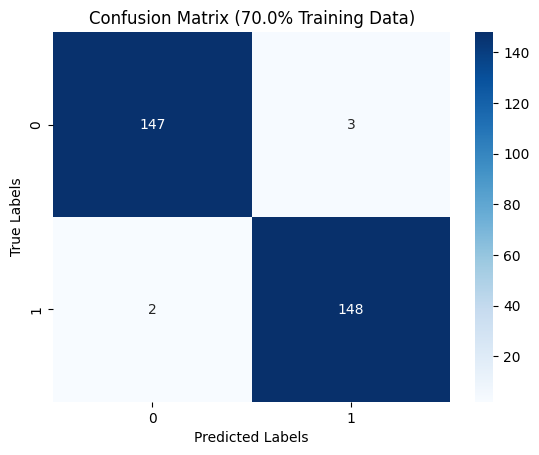

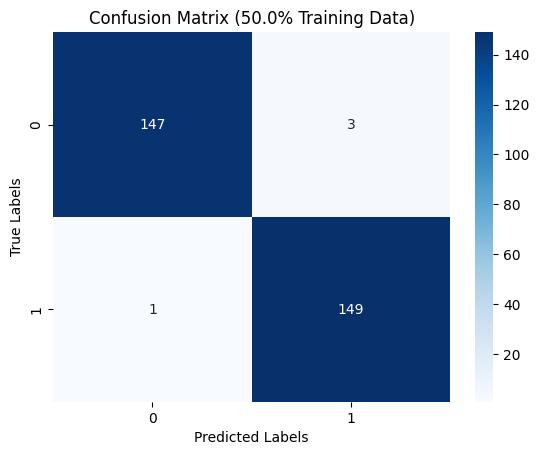

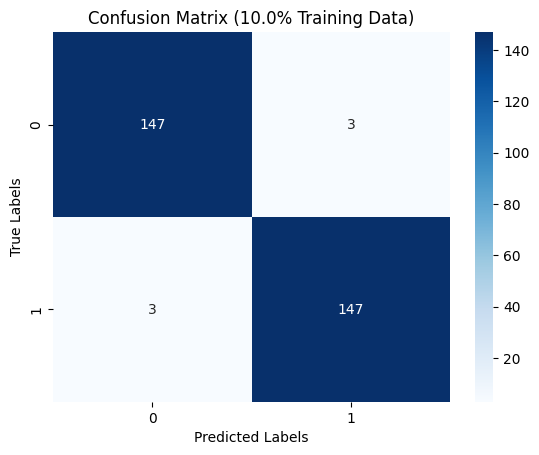

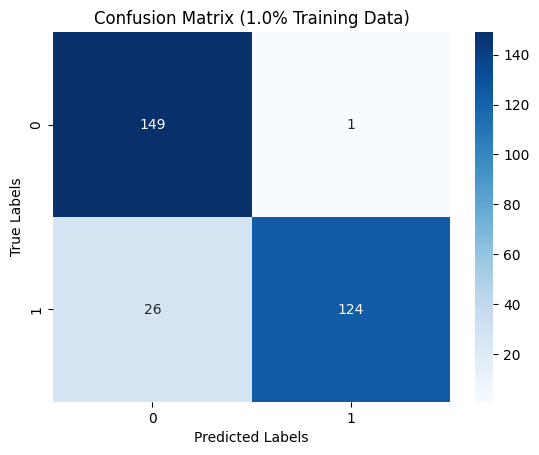

In [61]:
evaluate_con_mat(train_set, y_test, pred_KNN)

In [62]:
del acc_KNN, pred_KNN, train_data, pred_proba_KNN, best_params, clf_KNN

### XGBoostClassifier

In [63]:
def preprocess_data(df):
    # Make a copy to avoid modifying original
    df_processed = df.copy()
    
    # Check each problematic column
    for column in ['ZP', 'Cond', 'Mean Count Rate']:
        if column in df.columns:
            # If it's supposed to be numeric but stored as object
            try:
                df_processed[column] = pd.to_numeric(df[column])
            # If it's categorical
            except ValueError:
                # Convert to categorical type
                df_processed[column] = pd.Categorical(df[column]).codes
    
    return df_processed

In [64]:
X_train_processed = preprocess_data(X_train)
X_test_processed = preprocess_data(X_test)

In [65]:
eval_model =  evaluate_model(XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, enable_categorical=True), train_set, X_train_processed, y_train, X_test_processed, y_test)

Accuracy score(XGBClassifier model): 1.000000 with 70.0% training records
Execution Time(XGBClassifier model): 0.005457 seconds with 70.0% training records

Accuracy score(XGBClassifier model): 1.000000 with 50.0% training records
Execution Time(XGBClassifier model): 0.003849 seconds with 50.0% training records

Accuracy score(XGBClassifier model): 1.000000 with 10.0% training records
Execution Time(XGBClassifier model): 0.003242 seconds with 10.0% training records

Accuracy score(XGBClassifier model): 0.500000 with 1.0% training records
Execution Time(XGBClassifier model): 0.003056 seconds with 1.0% training records



In [66]:
#===============================Hyperparameter Tuning================================
clf_xgb = XGBClassifier(random_state=42, enable_categorical=True)
param_grid = {'n_estimators': [100, 200, 300],'learning_rate': [0.01, 0.1, 0.2],'max_depth': [3, 4, 5],'min_child_weight': [1, 3, 5],'subsample': [0.7, 0.8, 0.9],'colsample_bytree': [0.7, 0.8, 0.9]}
grid_search = GridSearchCV(clf_xgb, param_grid, cv=10, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train_processed, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}


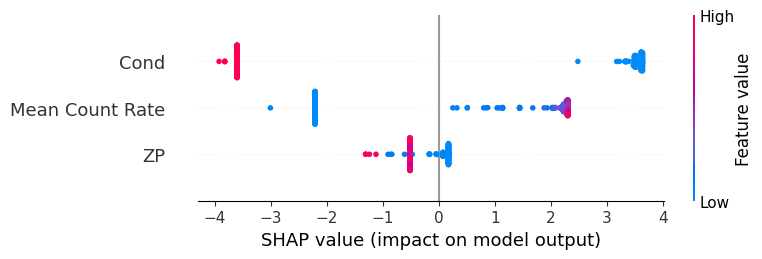

In [67]:
# Assuming best_model is your trained XGBoost model from grid_search
best_model = grid_search.best_estimator_
# Use TreeExplainer instead of LinearExplainer for XGBoost
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_processed)
shap.summary_plot(shap_values, X_test_processed)

### XGBoostClassifier with hyperparameter tuning

In [68]:
#==============================XGBoostClassifier Model with Hyperparameter Tuning===========================
acc_xgb, pred_xgb, train_data, pred_proba_xgb = evaluate_model(XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.2, max_depth = 3, min_child_weight = 1, n_estimators = 100, subsample = 0.7), train_set, X_train_processed, y_train, X_test_processed, y_test)

Accuracy score(XGBClassifier model): 1.000000 with 70.0% training records
Execution Time(XGBClassifier model): 0.002503 seconds with 70.0% training records

Accuracy score(XGBClassifier model): 1.000000 with 50.0% training records
Execution Time(XGBClassifier model): 0.002443 seconds with 50.0% training records

Accuracy score(XGBClassifier model): 1.000000 with 10.0% training records
Execution Time(XGBClassifier model): 0.002419 seconds with 10.0% training records

Accuracy score(XGBClassifier model): 0.500000 with 1.0% training records
Execution Time(XGBClassifier model): 0.002372 seconds with 1.0% training records



### Learning Curve for XGBoostClassifier (FeNP vs AgNP)

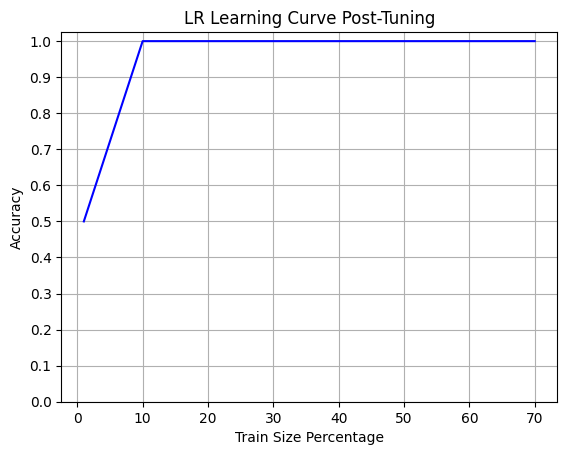

In [69]:
#===============================Learning Curve for LR===========================================
plt.plot(training_sample,acc_xgb, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for XGBoost Classifier (FeNP vs AgNP)

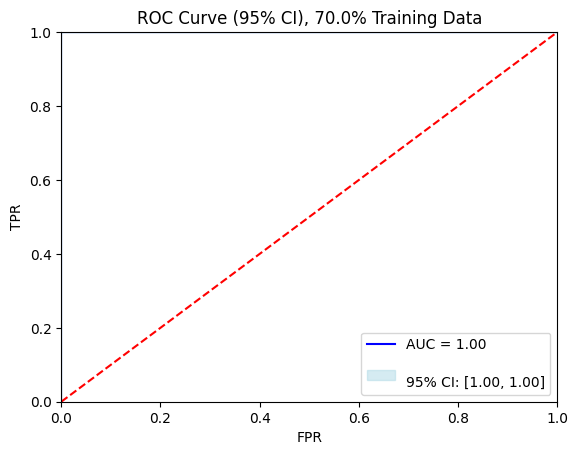

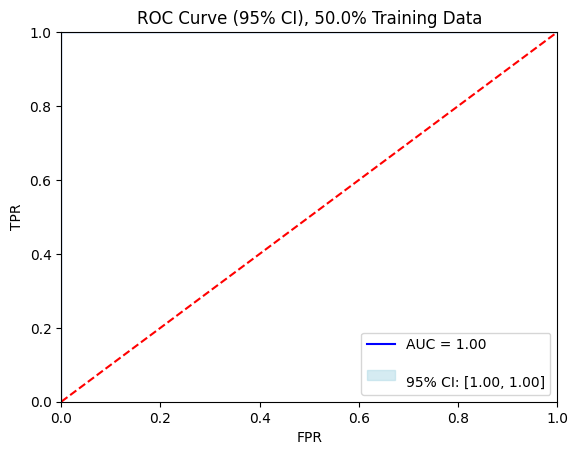

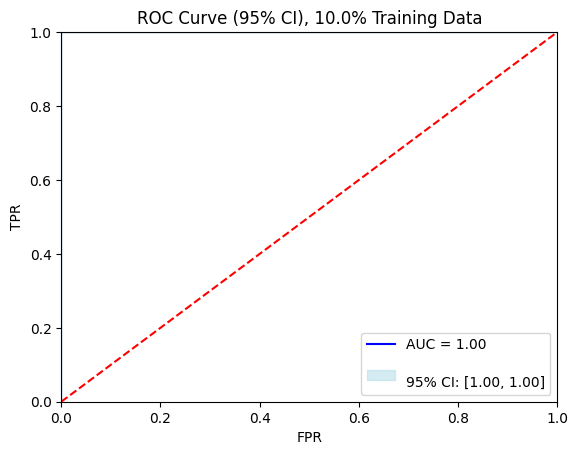

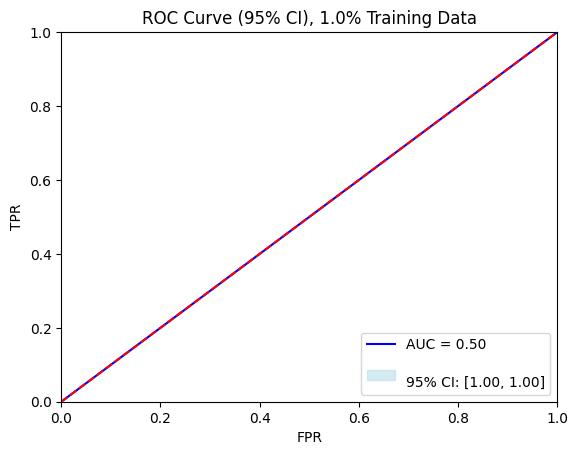

In [70]:
evaluate_ROC(train_set, y_test, pred_xgb)

### Confusion Matrix for XGBoostClassifier (FeNP vs AgNP)

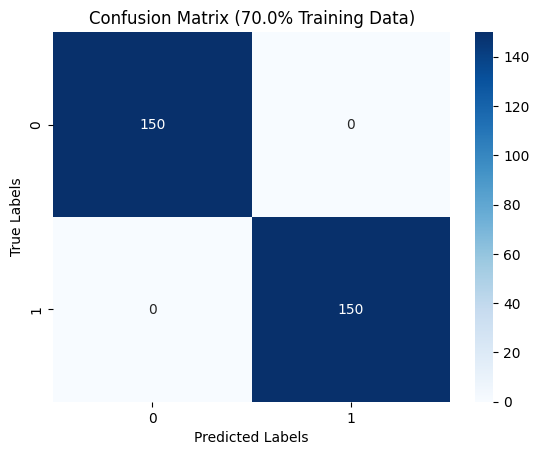

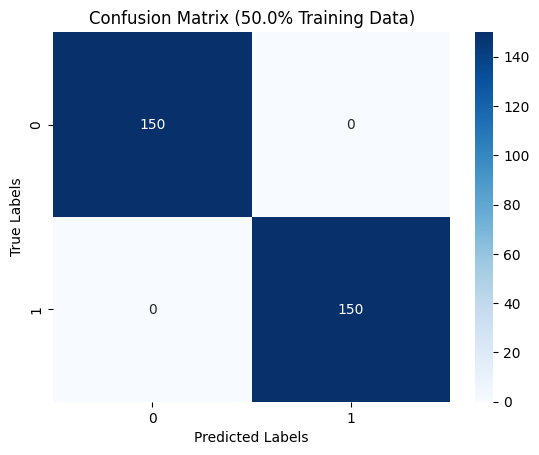

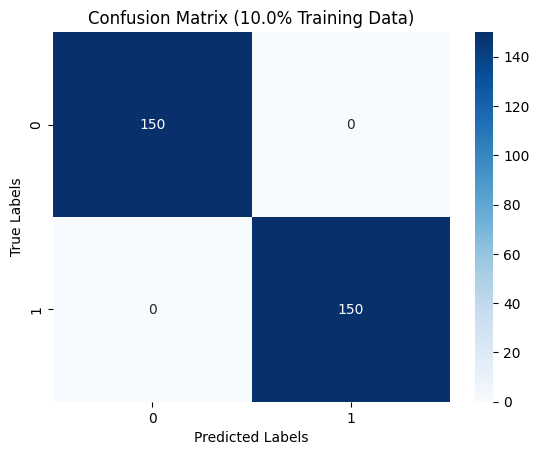

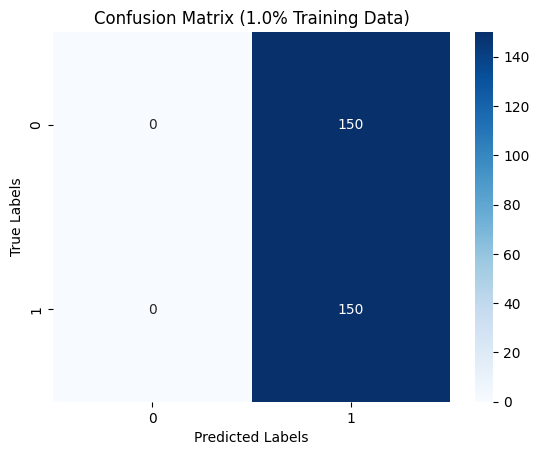

In [71]:
evaluate_con_mat(train_set, y_test, pred_xgb)

In [72]:
del acc_xgb, pred_xgb, train_data, pred_proba_xgb, best_params, clf_xgb

## Vector Quantum Classifier

In [73]:
#=====================Vector Quantum Classifier Model with different training sets================
scaler = MinMaxScaler()
train_features = scaler.fit_transform(X_train)
train_labels = y_train
test_features = scaler.transform(X_test)
test_labels = y_test
num_features = train_features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

In [74]:
# del X_train, y_train

In [75]:
ansatz = EfficientSU2(num_qubits=num_features,entanglement='sca', reps=2)

In [76]:
optimizer = op.COBYLA(maxiter=300)

In [77]:
sampler = Sampler()

### Vector Quantum Classifier with Hyperparameter Tuning (FeNP vs AgNP)

In [78]:
#======================================VQC=================================================
clf_vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss = 'squared_error',
    optimizer=optimizer
)
acc_vqtask1 = []
pred_vqtask1 = []
for elm in train_set:
    vqc = copy.deepcopy(clf_vqc)
    X_t, dummy_x, y_t, dummy_y = train_test_split(train_features, train_labels, train_size=elm, random_state=algorithm_globals.random_seed)
    vqc.fit(X_t, y_t.values)
    start = time.time()
    pred = vqc.predict(test_features)
    end = time.time()
    accuracy = accuracy_score(test_labels.values, pred)
    execution_time = end-start
    pred_vqtask1.append(pred)
    acc_vqtask1.append(accuracy)
    print(f'Accuracy score(VQC Model): {accuracy} with {elm*100}% training records')
    print(f'Execution Time(VQC Model): {execution_time} seconds with {elm*100}% training records')
    print()
#======================================VQC=================================================

Accuracy score(VQC Model): 1.0 with 70.0% training records
Execution Time(VQC Model): 1.290865182876587 seconds with 70.0% training records

Accuracy score(VQC Model): 1.0 with 50.0% training records
Execution Time(VQC Model): 1.392765998840332 seconds with 50.0% training records

Accuracy score(VQC Model): 1.0 with 10.0% training records
Execution Time(VQC Model): 1.2852392196655273 seconds with 10.0% training records

Accuracy score(VQC Model): 1.0 with 1.0% training records
Execution Time(VQC Model): 1.3532943725585938 seconds with 1.0% training records



## Learning Curve for VQC

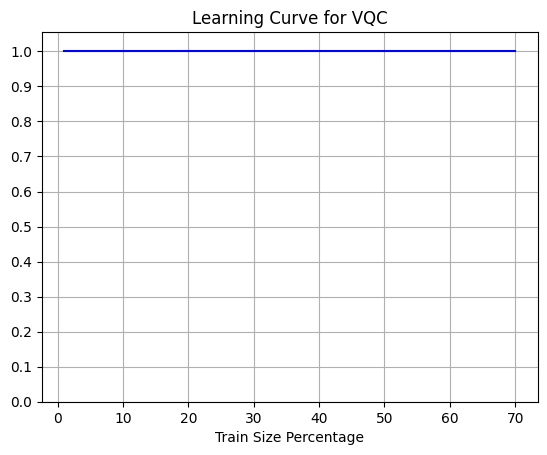

In [79]:
#===============================Learning Curve for VQC===========================================
plt.plot(training_sample,acc_vqtask1, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for VQC')
plt.show()

### 3D Scatter Plot for VQC Model (FeNP vs AgNP)

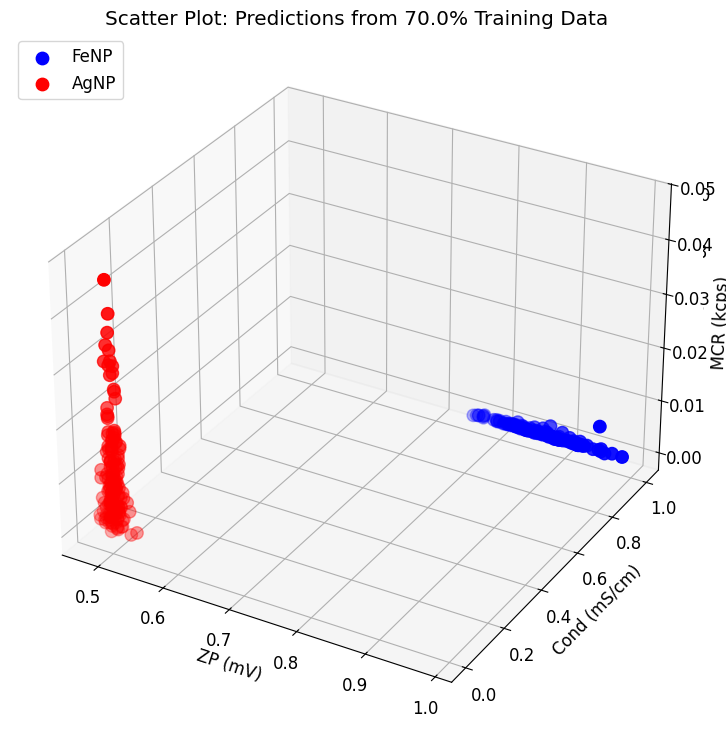

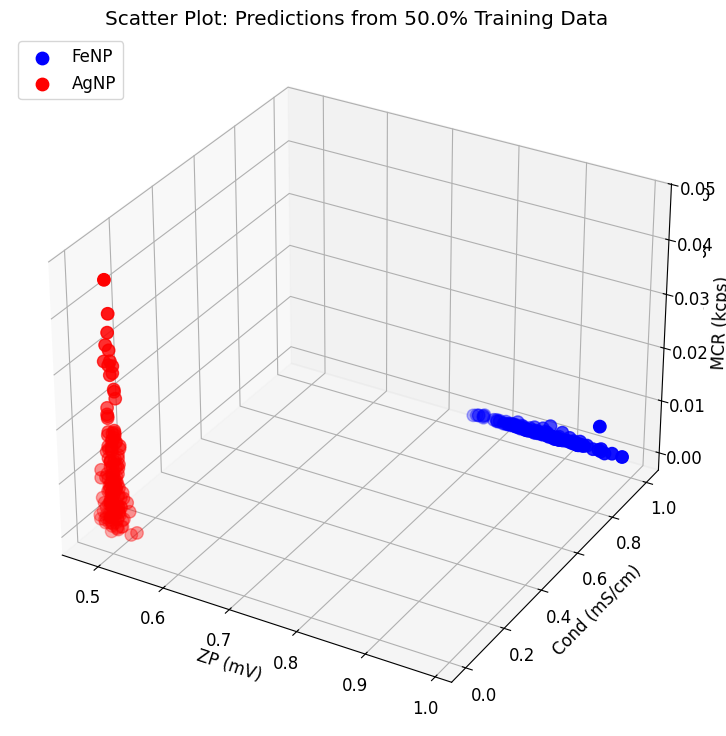

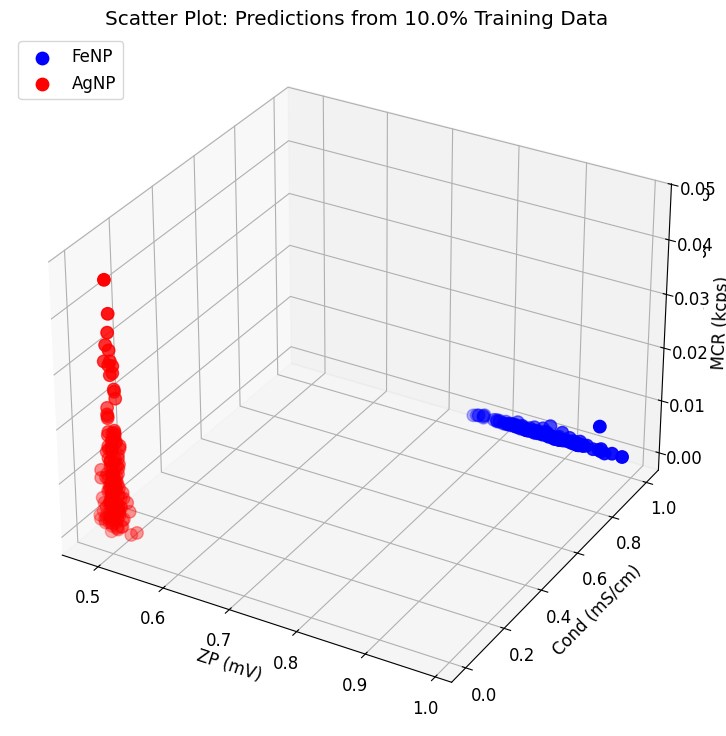

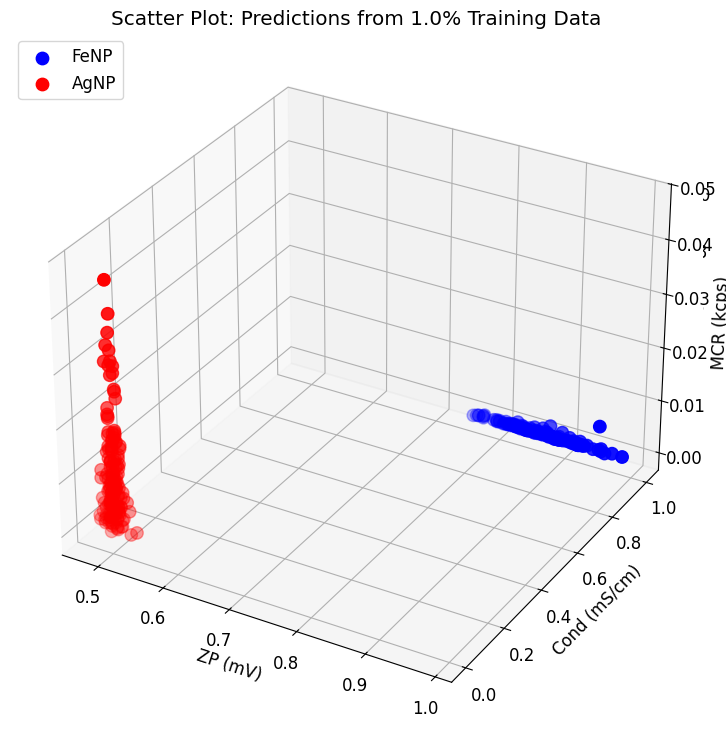

In [80]:
#=======================================3D Scatter Plot===============================
for i in range(len(train_set)):
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(1,1,1,projection='3d')
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(test_features[pred_vqtask1[i]==0,0], test_features[pred_vqtask1[i]==0,1], test_features[pred_vqtask1[i]==0,2], c='blue', marker='o', label='FeNP', s=80)
    ax.scatter(test_features[pred_vqtask1[i]==1,0], test_features[pred_vqtask1[i]==1,1], test_features[pred_vqtask1[i]==1,2], c='red', marker='o', label='AgNP',s=80)
  # Set labels for each axis
    ax.set_xlabel('ZP (mV)')
    ax.set_ylabel('Cond (mS/cm)')
    ax.set_zlabel('MCR (kcps)')
    ax.set_title(f'Scatter Plot: Predictions from {train_set[i]*100}% Training Data')
    ax.tick_params("z", which="major",length=15,width = 2.0)
    ax.legend(loc='upper left')
    plt.show()

### ROC Curve for Vector Quantum Classifier (FeNP vs AgNP)

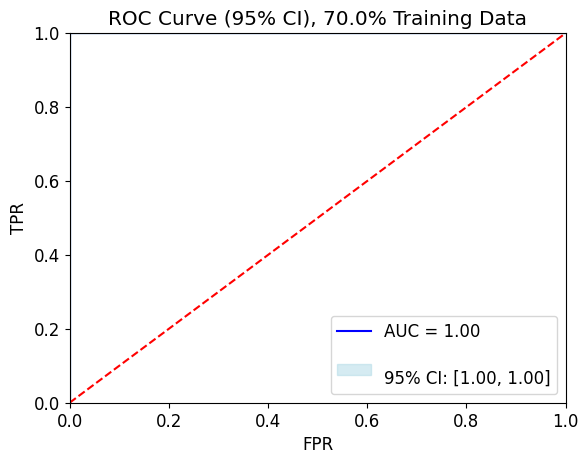

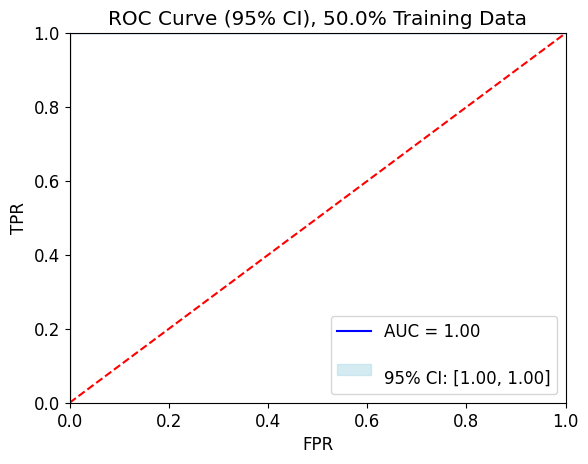

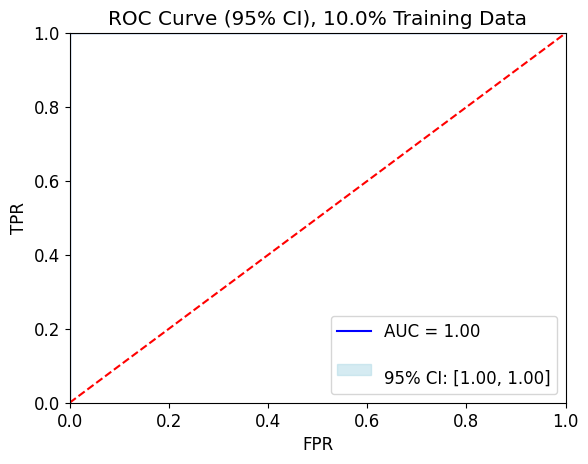

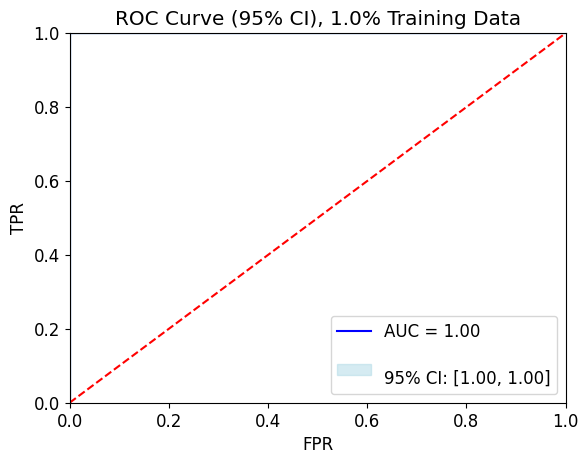

In [81]:
evaluate_ROC(train_set, test_labels, pred_vqtask1)

### Confusion Matrix for Vector Quantum Classifier (FeNP vs AgNP)

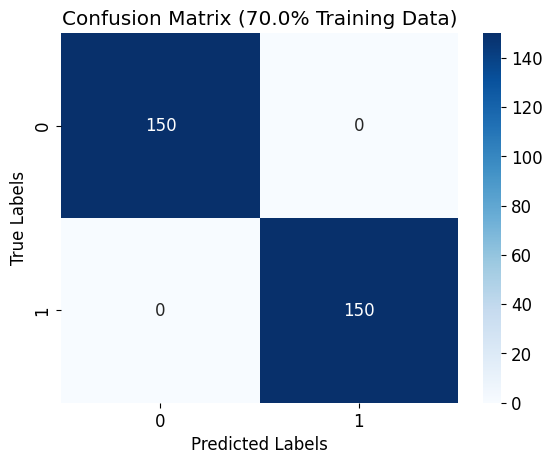

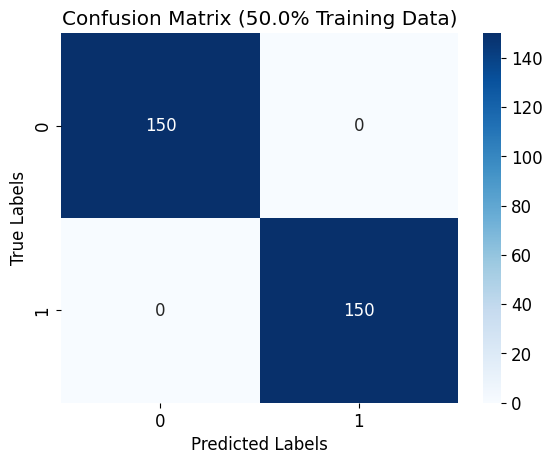

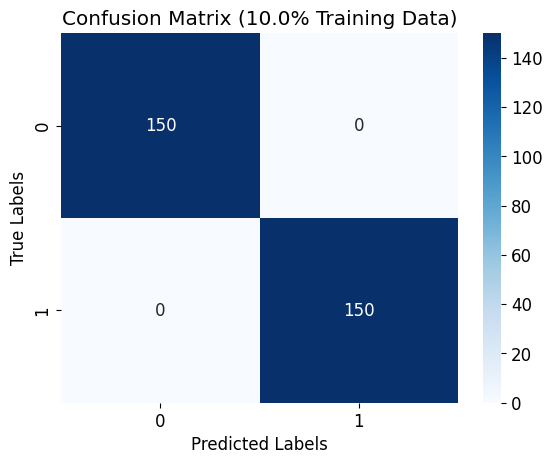

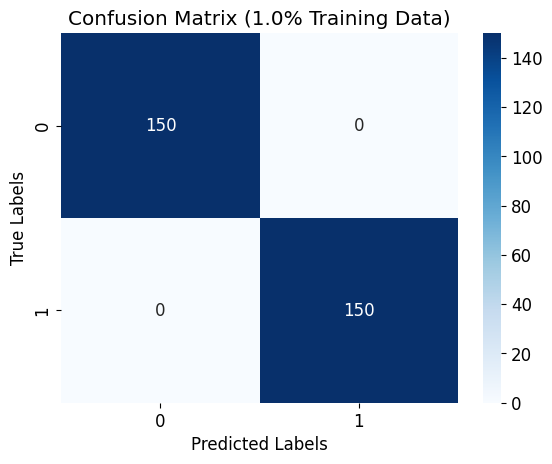

In [82]:
evaluate_con_mat(train_set, test_labels, pred_vqtask1)

# <center><h1><b>Task 2 (CoNP vs AgNP)</b></h1></center>

In [83]:
#==================Predictor Variables=====================================
X_train = dataset2[['ZP', 'Cond', 'Mean Count Rate']]
X_test = dataset4[['ZP', 'Cond', 'Mean Count Rate']]
#===================Output Variable========================================
y_train = dataset2['Sample Name'].apply(lambda x: 1 if x == 3 else 0)
y_test = dataset4['Sample Name'].apply(lambda x: 1 if x == 3 else 0)

## Logistic Regression
### Logistic Regression without hyperparameter tuning (CoNP vs AgNP)

In [84]:
#=====================Logistic Regression Model with different training sets================
eval_mod=evaluate_model(LogisticRegression(solver='lbfgs', max_iter=1000), train_set, X_train, y_train, X_test, y_test)

Accuracy score(LogisticRegression model): 1.000000 with 70.0% training records
Execution Time(LogisticRegression model): 0.002305 seconds with 70.0% training records

Accuracy score(LogisticRegression model): 1.000000 with 50.0% training records
Execution Time(LogisticRegression model): 0.001846 seconds with 50.0% training records

Accuracy score(LogisticRegression model): 0.986667 with 10.0% training records
Execution Time(LogisticRegression model): 0.001643 seconds with 10.0% training records

Accuracy score(LogisticRegression model): 0.983333 with 1.0% training records
Execution Time(LogisticRegression model): 0.001437 seconds with 1.0% training records



In [85]:
#===============================Hyperparameter Tuning================================
clf_LR = LogisticRegression(solver = 'lbfgs', max_iter=1000)
param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l2'], 'solver': ['newton-cg','lbfgs' ,'liblinear', 'saga']}
grid_search = GridSearchCV(clf_LR, param_grid, cv=10, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


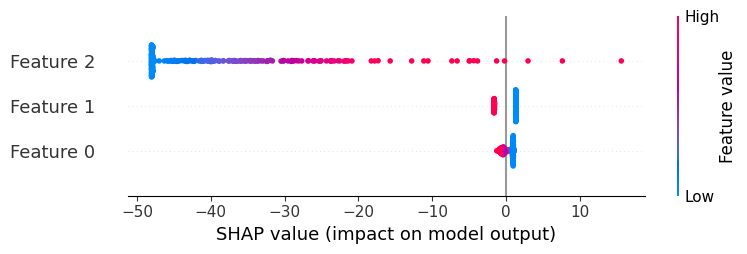

In [86]:
best_model = grid_search.best_estimator_
# Use SHAP's LinearExplainer with the best model
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)
    X_t = np.array(X_test, dtype=float)
    shap_values = np.array(shap_values, dtype=float)
shap.summary_plot(shap_values,X_t)

### Logistic Regression with hyperparameter tuning

In [87]:
#==============================Logistic Regression Model with Hyperparameter Tuning===========================
acc_LR, pred_LR, train_data, pred_proba_LR = evaluate_model(LogisticRegression(solver = best_params['solver'], penalty=best_params['penalty'], C = best_params['C']), train_set, X_train, y_train, X_test, y_test)

Accuracy score(LogisticRegression model): 1.000000 with 70.0% training records
Execution Time(LogisticRegression model): 0.002107 seconds with 70.0% training records

Accuracy score(LogisticRegression model): 1.000000 with 50.0% training records
Execution Time(LogisticRegression model): 0.001818 seconds with 50.0% training records

Accuracy score(LogisticRegression model): 1.000000 with 10.0% training records
Execution Time(LogisticRegression model): 0.001786 seconds with 10.0% training records

Accuracy score(LogisticRegression model): 1.000000 with 1.0% training records
Execution Time(LogisticRegression model): 0.001696 seconds with 1.0% training records



### Learning Curve for Logistic Regression (CoNP vs AgNP)

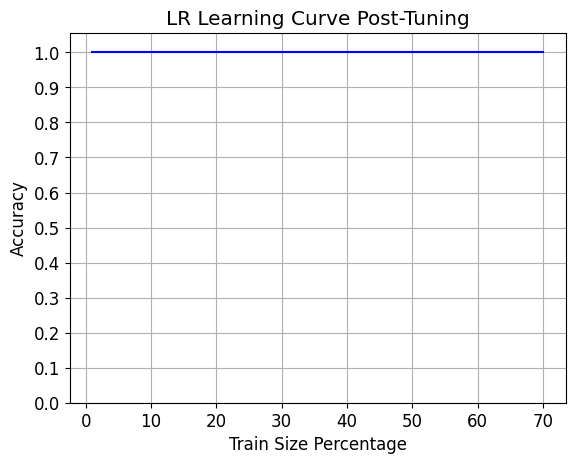

In [88]:
#===============================Learning Curve for LR===========================================
plt.plot(training_sample,acc_LR, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for Logistic Regression (CoNP vs AgNP)

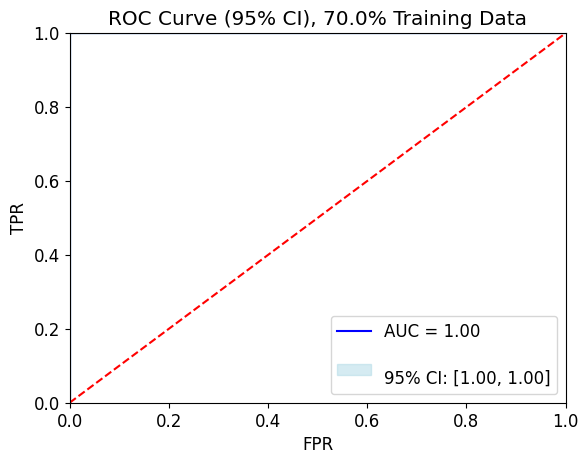

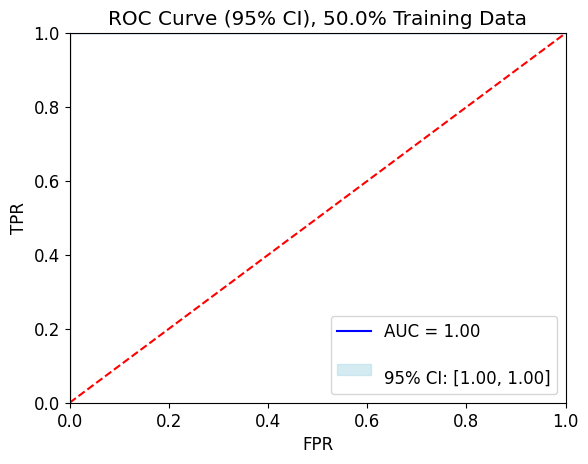

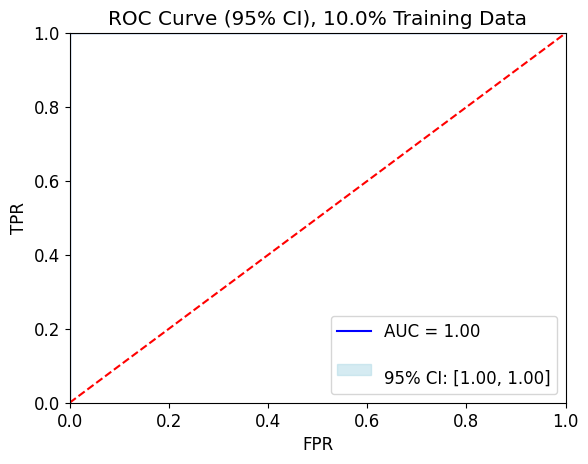

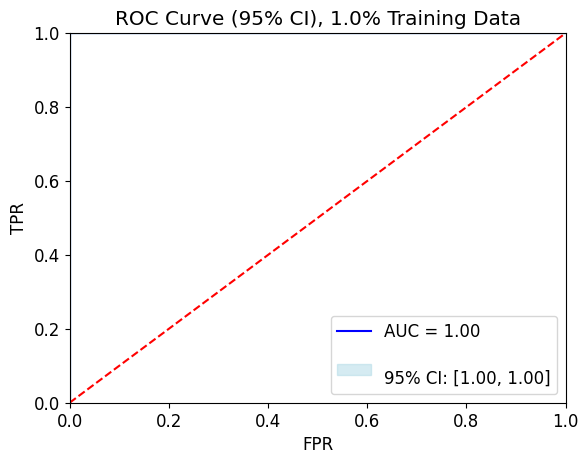

In [89]:
evaluate_ROC(train_set, y_test, pred_LR)

### Confusion Matrix for Logistic Regression (CoNP vs AgNP)

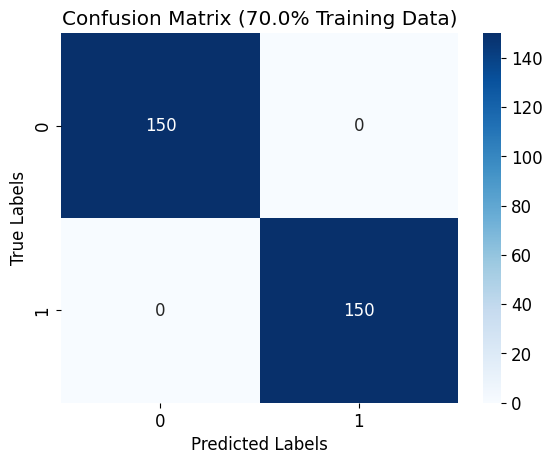

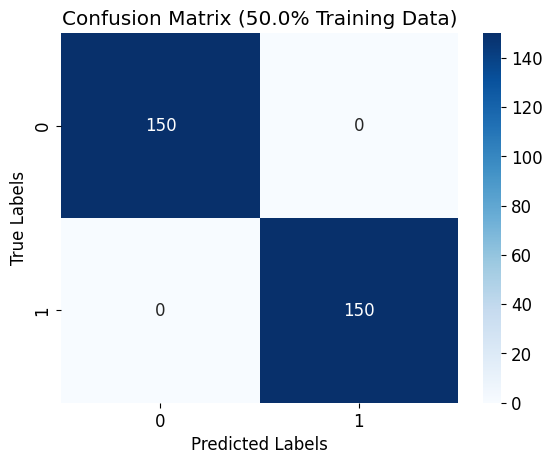

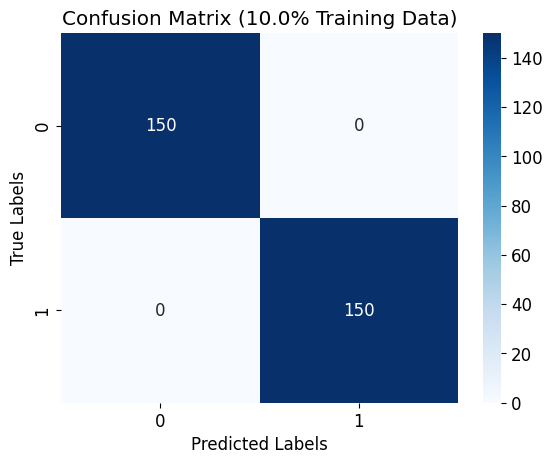

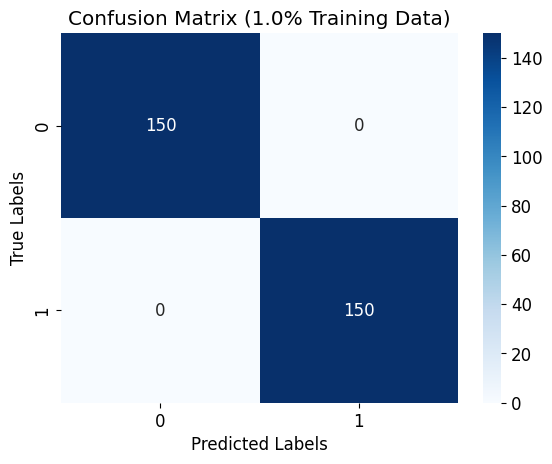

In [90]:
evaluate_con_mat(train_set, y_test, pred_LR)

In [91]:
del acc_LR, pred_LR, train_data, pred_proba_LR, best_params, clf_LR

## Decision Tree

### Decision Tree without hyperparameter tuning (CoNP vs AgNP)

In [92]:
eval_mod=evaluate_model(DecisionTreeClassifier(max_depth = 10,  min_samples_split = 10), train_set, X_train, y_train, X_test, y_test)

Accuracy score(DecisionTreeClassifier model): 0.900000 with 70.0% training records
Execution Time(DecisionTreeClassifier model): 0.002506 seconds with 70.0% training records

Accuracy score(DecisionTreeClassifier model): 1.000000 with 50.0% training records
Execution Time(DecisionTreeClassifier model): 0.002209 seconds with 50.0% training records

Accuracy score(DecisionTreeClassifier model): 0.986667 with 10.0% training records
Execution Time(DecisionTreeClassifier model): 0.002080 seconds with 10.0% training records

Accuracy score(DecisionTreeClassifier model): 0.500000 with 1.0% training records
Execution Time(DecisionTreeClassifier model): 0.001914 seconds with 1.0% training records



In [93]:
#==============================Hyperparameter  Tuning======================================
clf_DT = DecisionTreeClassifier(max_depth = 10,  min_samples_split = 10)
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(estimator=clf_DT, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': None, 'min_samples_split': 5}


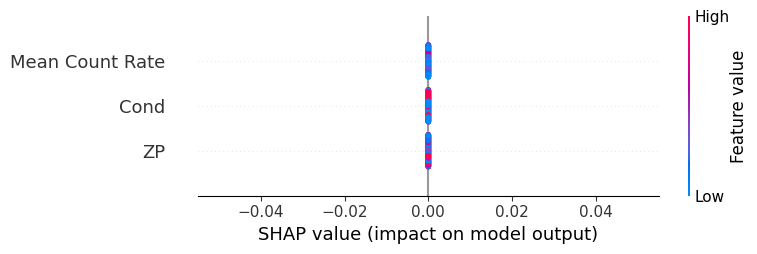

In [94]:
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
explainer_rf = shap.Explainer(grid_search.best_estimator_, X_train_norm)
shap_values_rf = explainer_rf(X_test_norm)
shap_values_class_1 = shap_values_rf.values[..., 1]
shap.summary_plot(shap_values_class_1, X_test_norm)

### Decision Tree with hyperparameter tuning (CoNP vs AgNP)

In [95]:
#==============================Random Forest Model with Hyperparameter Tuning===========================
acc_DT, pred_DT, train_data, pred_proba_DT = evaluate_model(grid_search.best_estimator_, train_set, X_train, y_train, X_test, y_test)

Accuracy score(DecisionTreeClassifier model): 1.000000 with 70.0% training records
Execution Time(DecisionTreeClassifier model): 0.001309 seconds with 70.0% training records

Accuracy score(DecisionTreeClassifier model): 1.000000 with 50.0% training records
Execution Time(DecisionTreeClassifier model): 0.001183 seconds with 50.0% training records

Accuracy score(DecisionTreeClassifier model): 1.000000 with 10.0% training records
Execution Time(DecisionTreeClassifier model): 0.001183 seconds with 10.0% training records

Accuracy score(DecisionTreeClassifier model): 1.000000 with 1.0% training records
Execution Time(DecisionTreeClassifier model): 0.001148 seconds with 1.0% training records



### Learning Curve for Decision Tree (CoNP vs AgNP)

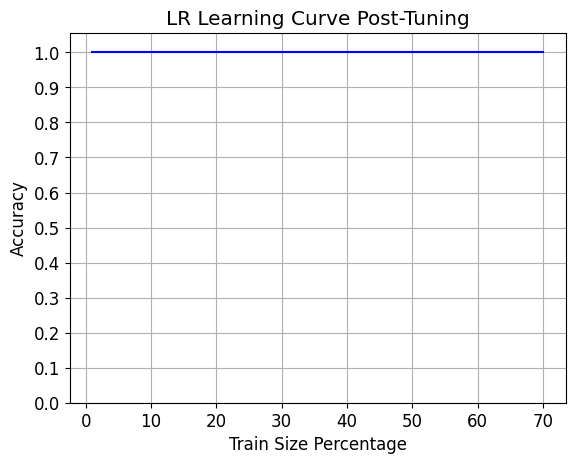

In [96]:
#===============================Learning Curve for Random Forest===========================================
plt.plot(training_sample,acc_DT, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for Decision Tree (CoNP vs AgNP)

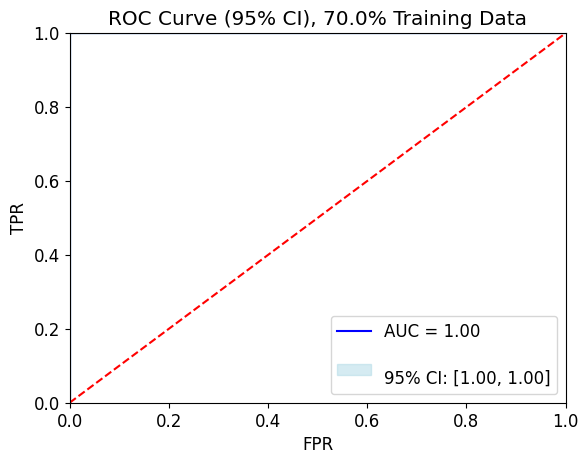

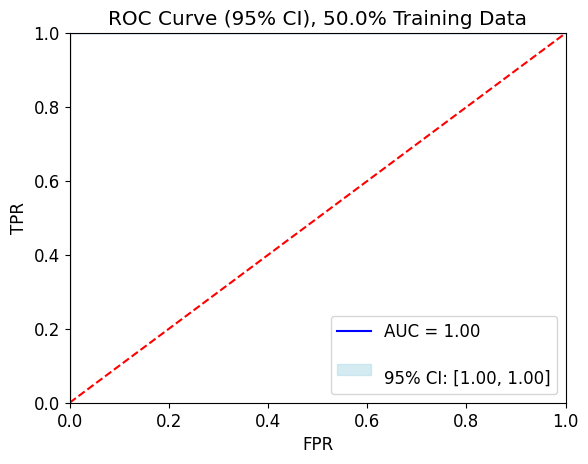

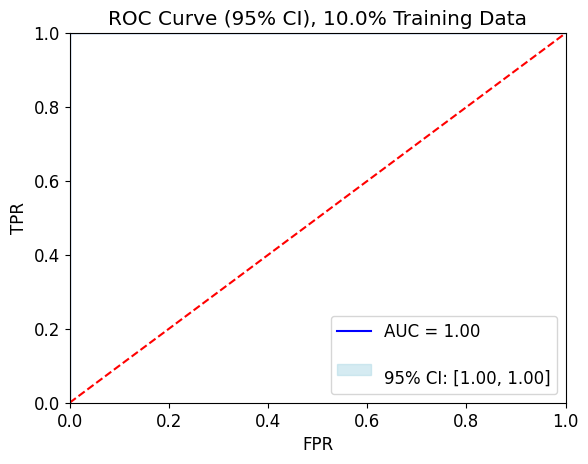

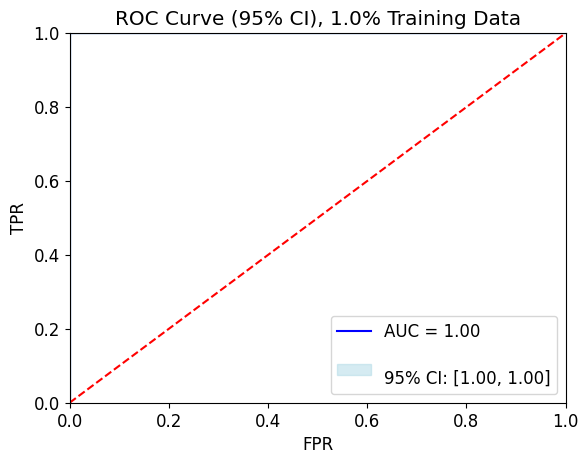

In [97]:
evaluate_ROC(train_set, y_test, pred_DT)

### Confusion Matrix for Decision Tree (CoNP vs AgNP)

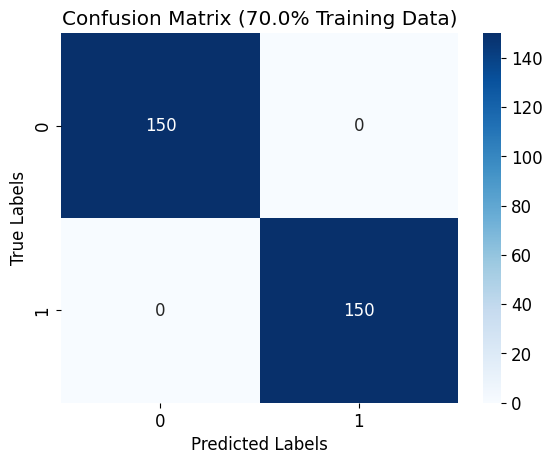

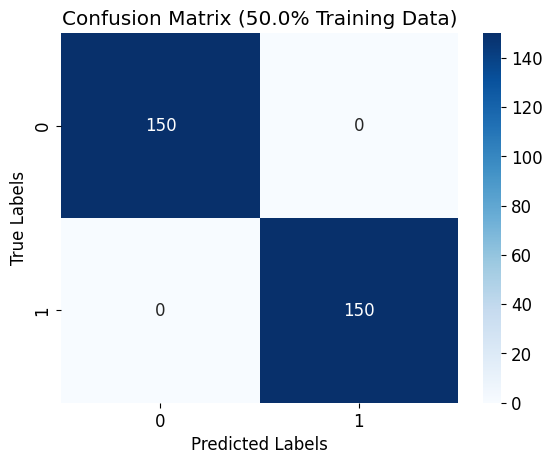

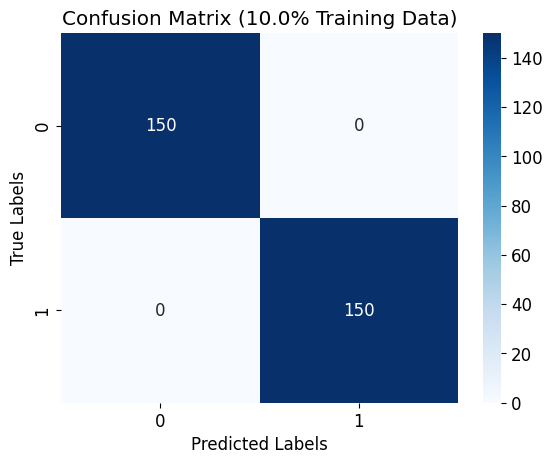

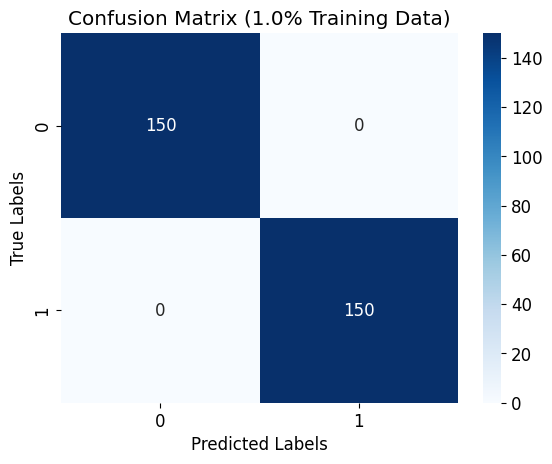

In [98]:
evaluate_con_mat(train_set, y_test, pred_DT)

In [99]:
del  acc_DT, pred_DT, train_data, pred_proba_DT, best_params, clf_DT

## Support Vector Classifier

### Support Vector Classifier  without hyperparameter tuning (CoNP vs AgNP)

In [100]:
eval_mod=evaluate_model(SVC(kernel='sigmoid', probability=True, C = 100, gamma='auto'), train_set, X_train, y_train, X_test, y_test)

Accuracy score(SVC model): 0.500000 with 70.0% training records
Execution Time(SVC model): 0.006900 seconds with 70.0% training records

Accuracy score(SVC model): 0.500000 with 50.0% training records
Execution Time(SVC model): 0.004409 seconds with 50.0% training records

Accuracy score(SVC model): 0.500000 with 10.0% training records
Execution Time(SVC model): 0.002044 seconds with 10.0% training records

Accuracy score(SVC model): 0.500000 with 1.0% training records
Execution Time(SVC model): 0.001521 seconds with 1.0% training records



In [101]:
#==========================Hyperparameter Tuning==========================
clf_SVM = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1]
}
grid_search = GridSearchCV(estimator=clf_SVM, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

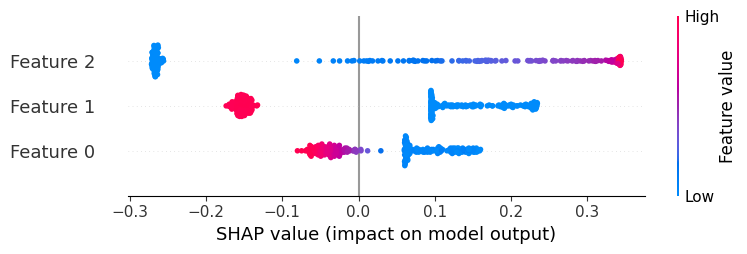

In [102]:
best_model = grid_search.best_estimator_
explainer_svc = shap.KernelExplainer(best_model.predict_proba, X_train)
# shap_values = np.array(X_t, dtype=float)
shap_values_svc = explainer_svc(X_test)
shap_values_svc_class_1 = shap_values_svc.values[..., 1]
shap.summary_plot(shap_values_svc_class_1, X_t)

### Support Vector Classifier with hyperparameter tuning (CoNP vs AgNP)

In [103]:
acc_SVC, pred_SVC, train_data, pred_proba_SVC=evaluate_model(grid_search.best_estimator_, train_set, X_train, y_train, X_test, y_test)

Accuracy score(SVC model): 1.000000 with 70.0% training records
Execution Time(SVC model): 0.000990 seconds with 70.0% training records

Accuracy score(SVC model): 1.000000 with 50.0% training records
Execution Time(SVC model): 0.000958 seconds with 50.0% training records

Accuracy score(SVC model): 0.986667 with 10.0% training records
Execution Time(SVC model): 0.000983 seconds with 10.0% training records

Accuracy score(SVC model): 0.983333 with 1.0% training records
Execution Time(SVC model): 0.000962 seconds with 1.0% training records



### Learning Curve for Support Vector Classifier (CoNP vs AgNP)

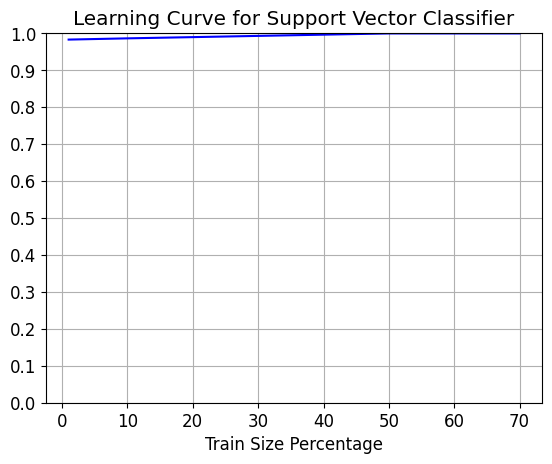

In [104]:
#===============================Learning Curve for SVC===========================================
plt.plot(training_sample,acc_SVC, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for Support Vector Classifier')
plt.show()

### ROC Curve for Support Vector Classifier (CoNP vs AgNP)

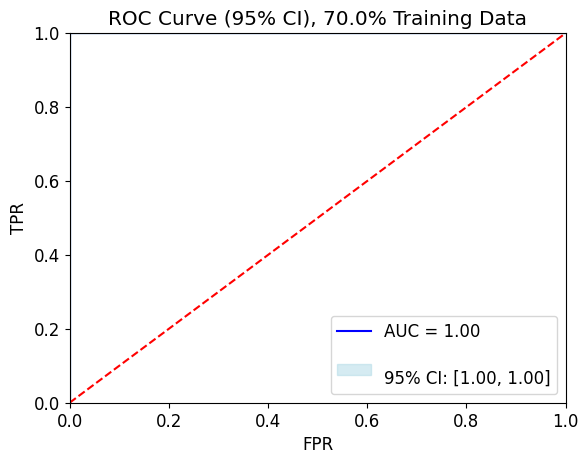

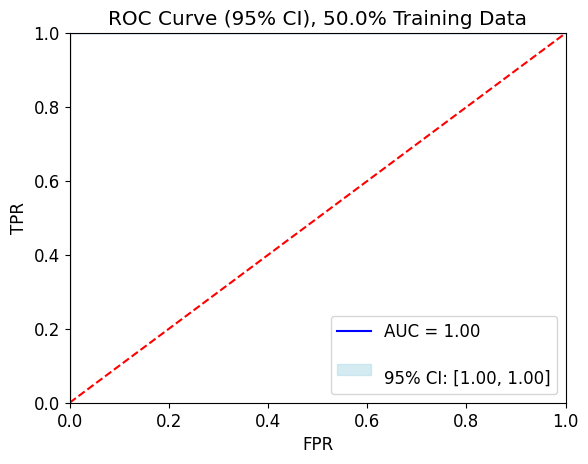

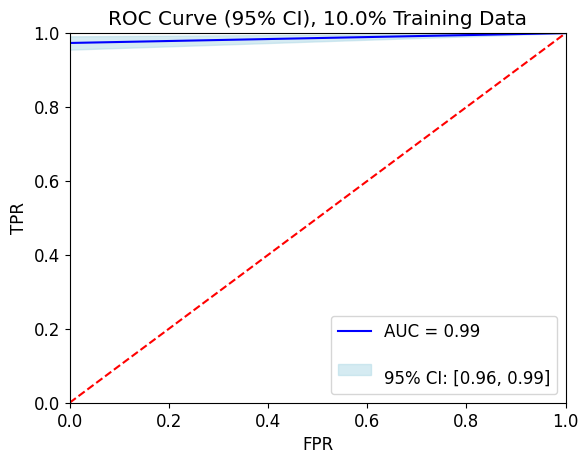

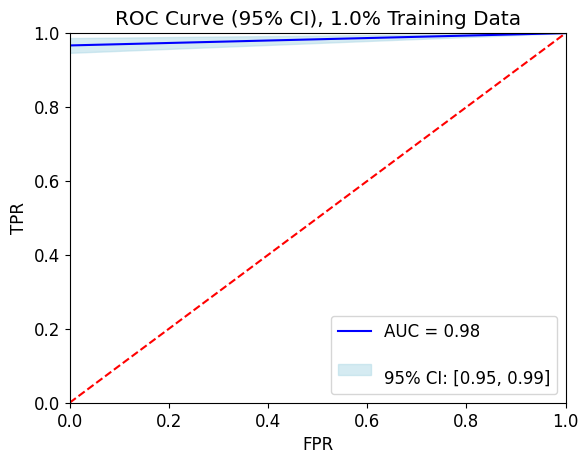

In [105]:
evaluate_ROC(train_set, y_test, pred_SVC)

### Confusion Matrix for Support Vector Classifier (CoNP vs AgNP)

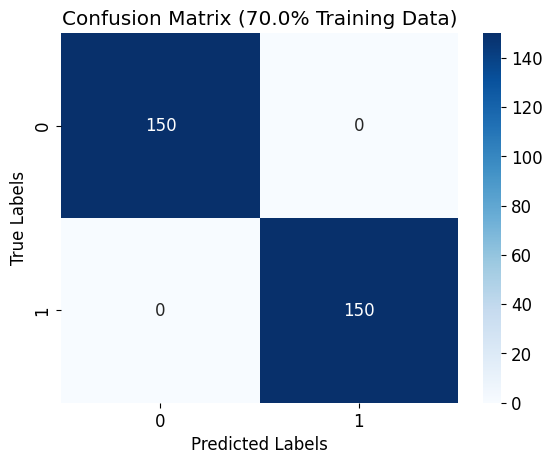

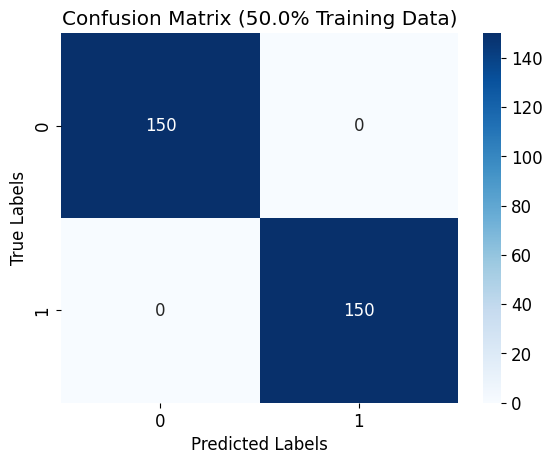

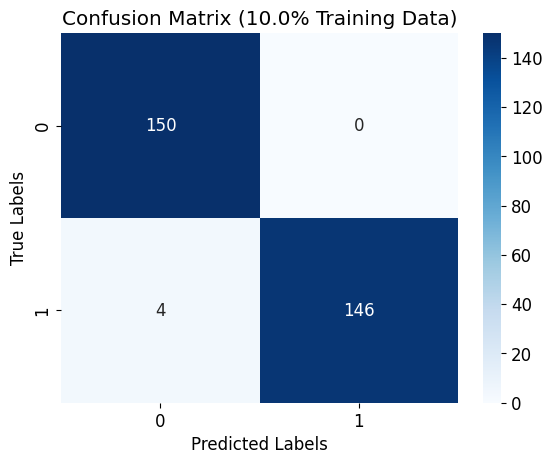

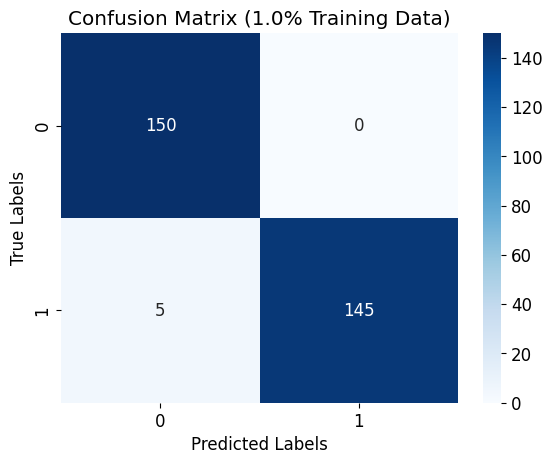

In [106]:
evaluate_con_mat(train_set, y_test, pred_SVC)

In [107]:
del acc_SVC, pred_SVC, train_data, pred_proba_SVC, best_params, clf_SVM

## KNN Classifier

In [108]:
eval_mod=evaluate_model(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean'), train_set, X_train, y_train, X_test, y_test)

Accuracy score(KNeighborsClassifier model): 0.993333 with 70.0% training records
Execution Time(KNeighborsClassifier model): 0.004759 seconds with 70.0% training records

Accuracy score(KNeighborsClassifier model): 0.976667 with 50.0% training records
Execution Time(KNeighborsClassifier model): 0.004010 seconds with 50.0% training records

Accuracy score(KNeighborsClassifier model): 0.986667 with 10.0% training records
Execution Time(KNeighborsClassifier model): 0.003418 seconds with 10.0% training records

Accuracy score(KNeighborsClassifier model): 0.853333 with 1.0% training records
Execution Time(KNeighborsClassifier model): 0.050368 seconds with 1.0% training records



In [109]:
#===============================Hyperparameter Tuning================================
clf_KNN = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(clf_KNN, param_grid, cv=10, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

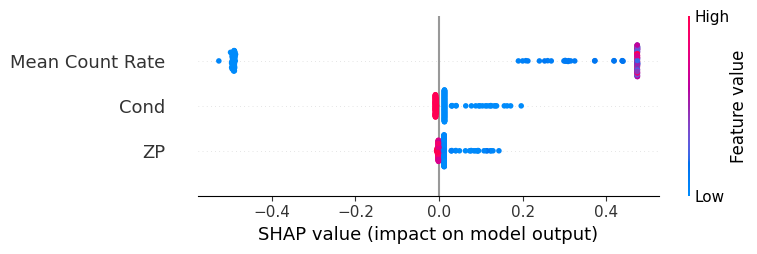

In [110]:
best_model = grid_search.best_estimator_
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train)
    shap_values = explainer.shap_values(X_test)
    X_t = np.array(X_test, dtype=float)
    shap_values = np.array(shap_values, dtype=float)

shap.summary_plot(shap_values[:, :, 1], X_t, feature_names=X_train.columns if hasattr(X_train, 'columns') else None)

### KNN Classifier with hyperparameter tuning

In [111]:
#==============================KNN Model with Hyperparameter Tuning===========================
acc_KNN, pred_KNN, train_data, pred_proba_KNN = evaluate_model(KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean'), train_set, X_train, y_train, X_test, y_test)

Accuracy score(KNeighborsClassifier model): 0.993333 with 70.0% training records
Execution Time(KNeighborsClassifier model): 0.003891 seconds with 70.0% training records

Accuracy score(KNeighborsClassifier model): 0.980000 with 50.0% training records
Execution Time(KNeighborsClassifier model): 0.003281 seconds with 50.0% training records

Accuracy score(KNeighborsClassifier model): 0.986667 with 10.0% training records
Execution Time(KNeighborsClassifier model): 0.002772 seconds with 10.0% training records

Accuracy score(KNeighborsClassifier model): 0.900000 with 1.0% training records
Execution Time(KNeighborsClassifier model): 0.002987 seconds with 1.0% training records



### Learning Curve for KNN (CoNP vs AgNP)

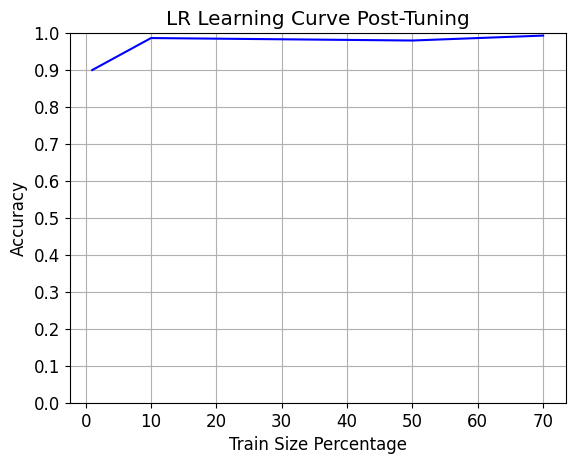

In [112]:
#===============================Learning Curve for LR===========================================
plt.plot(training_sample,acc_KNN, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for KNN (CoNP vs AgNP)

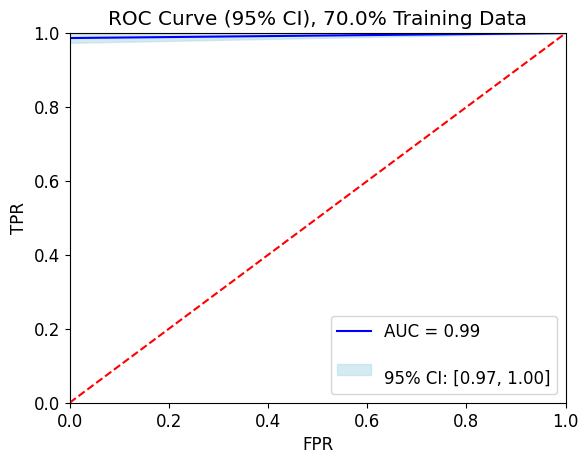

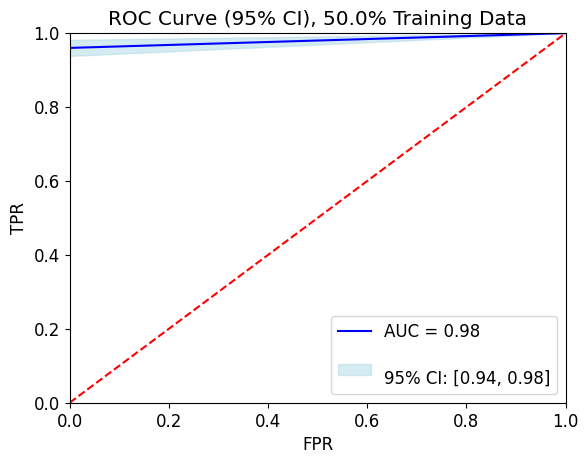

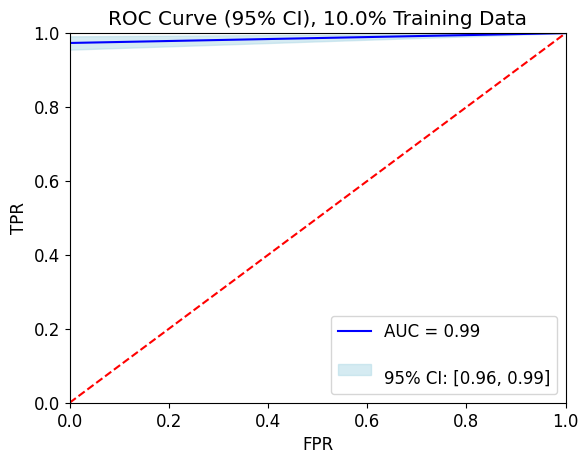

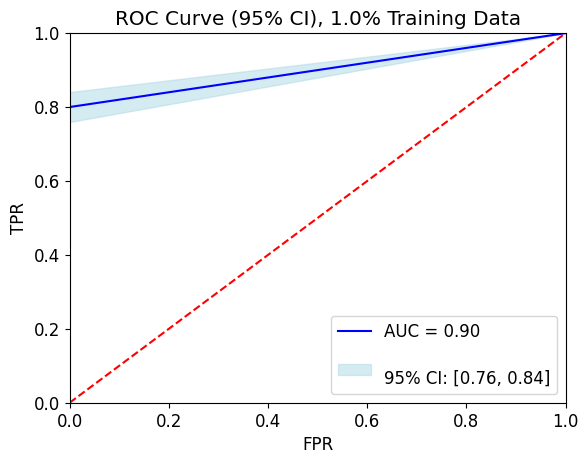

In [113]:
evaluate_ROC(train_set, y_test, pred_KNN)

### Confusion Matrix for KNN (CoNP vs AgNP)

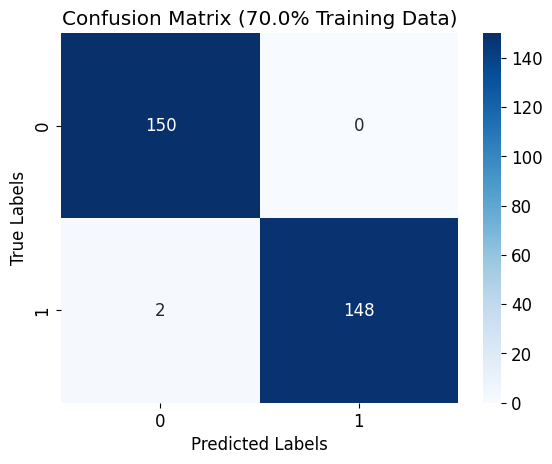

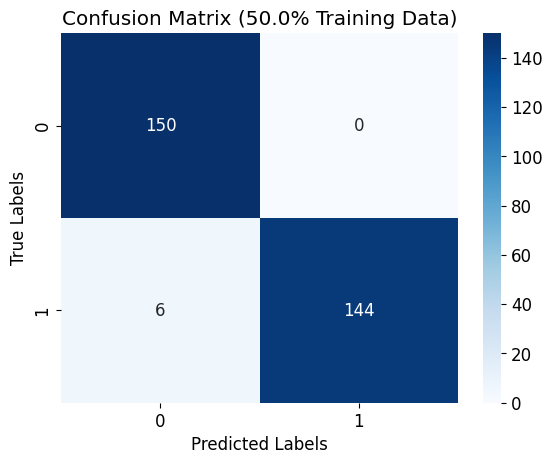

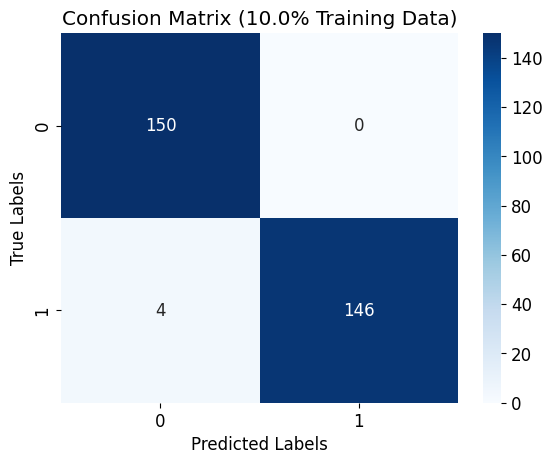

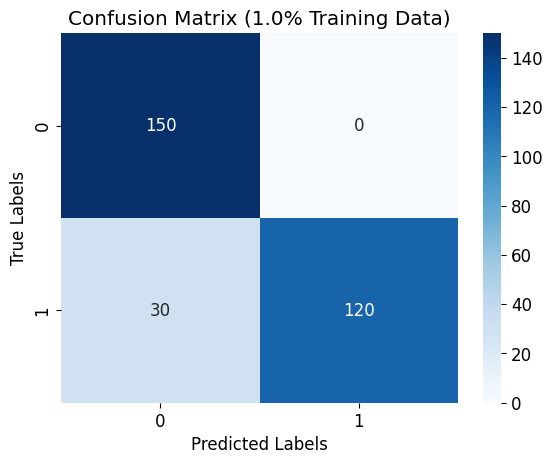

In [114]:
evaluate_con_mat(train_set, y_test, pred_KNN)

In [115]:
del acc_KNN, pred_KNN, train_data, pred_proba_KNN, best_params, clf_KNN

### XGBoostClassifier

In [116]:
def preprocess_data(df):
    # Make a copy to avoid modifying original
    df_processed = df.copy()
    
    # Check each problematic column
    for column in ['ZP', 'Cond', 'Mean Count Rate']:
        if column in df.columns:
            # If it's supposed to be numeric but stored as object
            try:
                df_processed[column] = pd.to_numeric(df[column])
            # If it's categorical
            except ValueError:
                # Convert to categorical type
                df_processed[column] = pd.Categorical(df[column]).codes
    
    return df_processed

In [117]:
X_train_processed = preprocess_data(X_train)
X_test_processed = preprocess_data(X_test)

In [118]:
eval_model =  evaluate_model(XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, enable_categorical=True), train_set, X_train_processed, y_train, X_test_processed, y_test)

Accuracy score(XGBClassifier model): 0.696667 with 70.0% training records
Execution Time(XGBClassifier model): 0.005181 seconds with 70.0% training records

Accuracy score(XGBClassifier model): 0.693333 with 50.0% training records
Execution Time(XGBClassifier model): 0.003827 seconds with 50.0% training records

Accuracy score(XGBClassifier model): 0.586667 with 10.0% training records
Execution Time(XGBClassifier model): 0.005649 seconds with 10.0% training records

Accuracy score(XGBClassifier model): 0.500000 with 1.0% training records
Execution Time(XGBClassifier model): 0.003045 seconds with 1.0% training records



In [119]:
#===============================Hyperparameter Tuning================================
clf_xgb = XGBClassifier(random_state=42, enable_categorical=True)
param_grid = {'n_estimators': [100, 200, 300],'learning_rate': [0.01, 0.1, 0.2],'max_depth': [3, 4, 5],'min_child_weight': [1, 3, 5],'subsample': [0.7, 0.8, 0.9],'colsample_bytree': [0.7, 0.8, 0.9]}
grid_search = GridSearchCV(clf_xgb, param_grid, cv=10, verbose=0 ,scoring='accuracy')
grid_search.fit(X_train_processed, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}


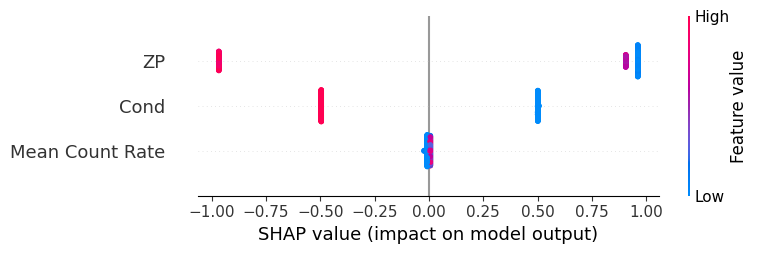

In [120]:
# Assuming best_model is your trained XGBoost model from grid_search
best_model = grid_search.best_estimator_
# Use TreeExplainer instead of LinearExplainer for XGBoost
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_processed)
shap.summary_plot(shap_values, X_test_processed)

### XGBoostClassifier with hyperparameter tuning

In [121]:
#==============================XGBoostClassifier Model with Hyperparameter Tuning===========================
acc_xgb, pred_xgb, train_data, pred_proba_xgb = evaluate_model(XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.2, max_depth = 3, min_child_weight = 1, n_estimators = 100, subsample = 0.7), train_set, X_train_processed, y_train, X_test_processed, y_test)

Accuracy score(XGBClassifier model): 0.696667 with 70.0% training records
Execution Time(XGBClassifier model): 0.002433 seconds with 70.0% training records

Accuracy score(XGBClassifier model): 0.693333 with 50.0% training records
Execution Time(XGBClassifier model): 0.002489 seconds with 50.0% training records

Accuracy score(XGBClassifier model): 0.980000 with 10.0% training records
Execution Time(XGBClassifier model): 0.002333 seconds with 10.0% training records

Accuracy score(XGBClassifier model): 0.500000 with 1.0% training records
Execution Time(XGBClassifier model): 0.002383 seconds with 1.0% training records



### Learning Curve for XGBoostClassifier (CoNP vs AgNP)

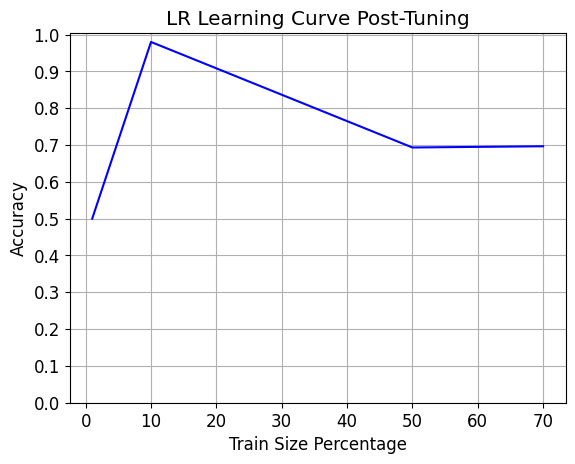

In [122]:
#===============================Learning Curve for LR===========================================
plt.plot(training_sample,acc_xgb, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.ylabel('Accuracy')
plt.title('LR Learning Curve Post-Tuning')
plt.show()

### ROC Curve for XGBoost Classifier (CoNP vs AgNP)

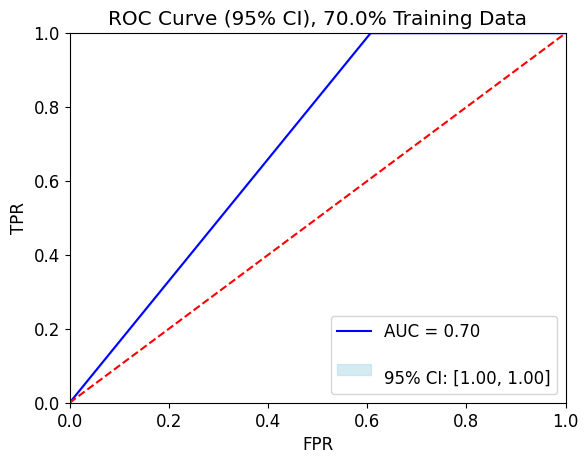

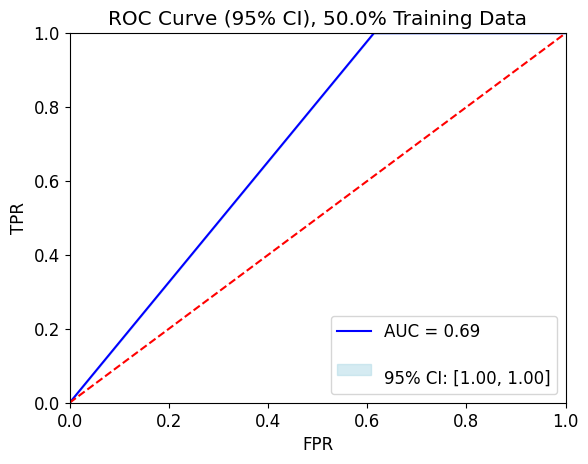

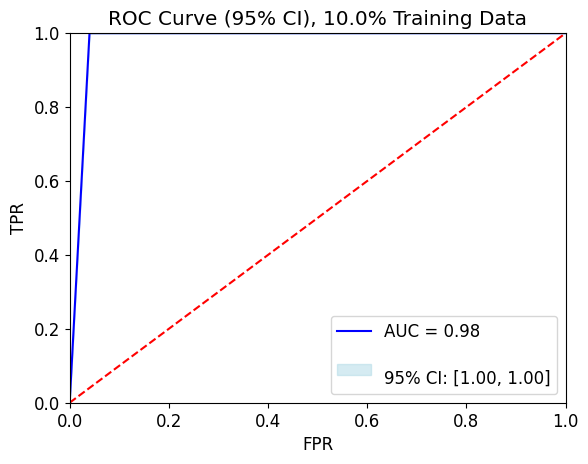

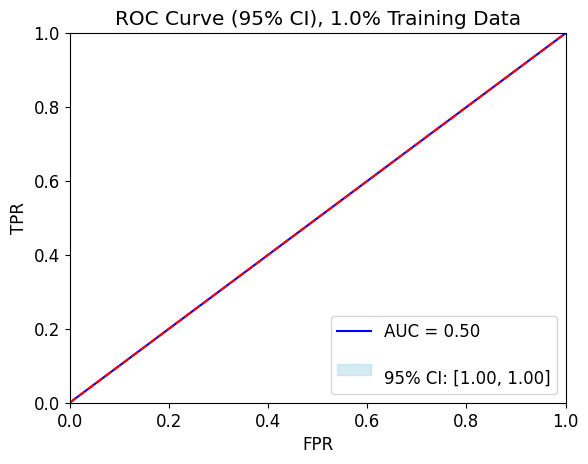

In [123]:
evaluate_ROC(train_set, y_test, pred_xgb)

### Confusion Matrix for XGBoostClassifier (FeNP vs AgNP)

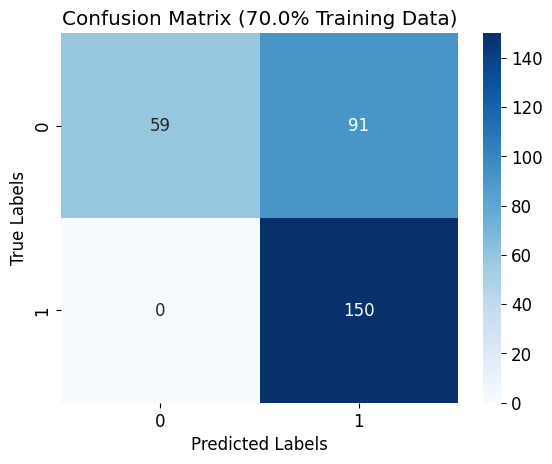

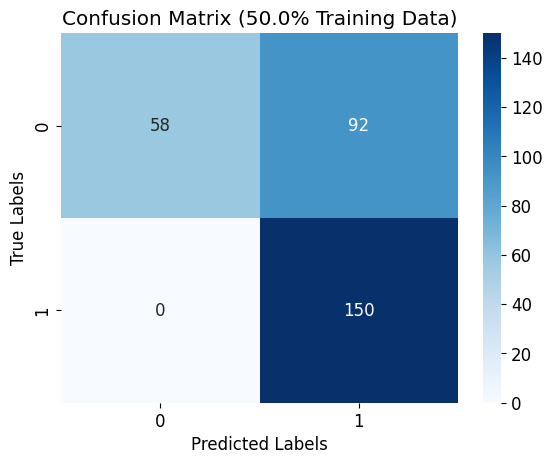

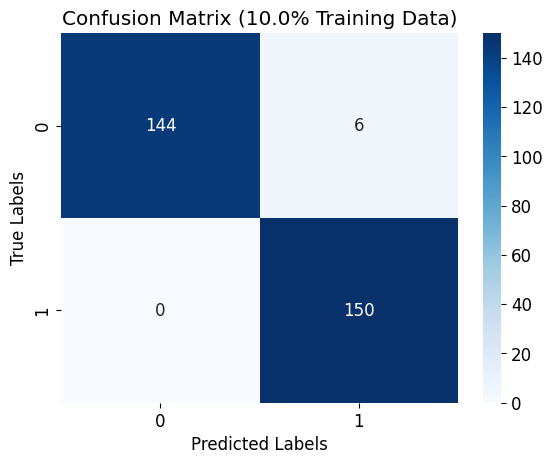

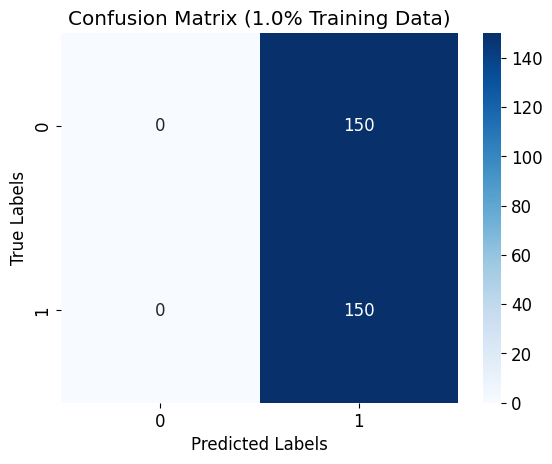

In [124]:
evaluate_con_mat(train_set, y_test, pred_xgb)

In [125]:
del acc_xgb, pred_xgb, train_data, pred_proba_xgb, best_params, clf_xgb

## Vector Quantum Classifier

In [126]:
#=====================Vector Quantum Classifier Model with different training sets================
scaler = MinMaxScaler()
train_features = scaler.fit_transform(X_train)
train_labels = y_train
test_features = scaler.transform(X_test)
test_labels = y_test
num_features = train_features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

In [127]:
# del X_train, y_train

In [128]:
ansatz = EfficientSU2(num_qubits=num_features,entanglement='sca', reps=2)

In [129]:
optimizer = op.COBYLA(maxiter=300)

In [130]:
sampler = Sampler()

### Vector Quantum Classifier with Hyperparameter Tuning (CoNP vs AgNP)

In [131]:
#======================================VQC=================================================
clf_vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss = 'squared_error',
    optimizer=optimizer
)
acc_vqtask1 = []
pred_vqtask1 = []
for elm in train_set:
    vqc = copy.deepcopy(clf_vqc)
    X_t, dummy_x, y_t, dummy_y = train_test_split(train_features, train_labels, train_size=elm, random_state=algorithm_globals.random_seed)
    vqc.fit(X_t, y_t.values)
    start = time.time()
    pred = vqc.predict(test_features)
    end = time.time()
    accuracy = accuracy_score(test_labels.values, pred)
    execution_time = end-start
    pred_vqtask1.append(pred)
    acc_vqtask1.append(accuracy)
    print(f'Accuracy score(VQC Model): {accuracy} with {elm*100}% training records')
    print(f'Execution Time(VQC Model): {execution_time} seconds with {elm*100}% training records')
    print()
#======================================VQC=================================================

Accuracy score(VQC Model): 1.0 with 70.0% training records
Execution Time(VQC Model): 1.4200921058654785 seconds with 70.0% training records

Accuracy score(VQC Model): 1.0 with 50.0% training records
Execution Time(VQC Model): 1.42311429977417 seconds with 50.0% training records

Accuracy score(VQC Model): 1.0 with 10.0% training records
Execution Time(VQC Model): 1.3905713558197021 seconds with 10.0% training records

Accuracy score(VQC Model): 0.9533333333333334 with 1.0% training records
Execution Time(VQC Model): 1.3473756313323975 seconds with 1.0% training records



## Learning Curve for VQC

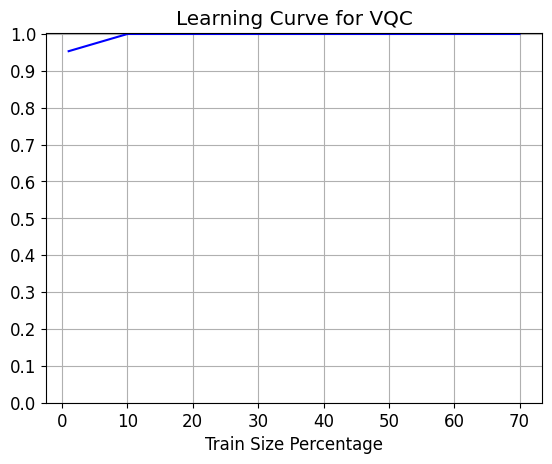

In [132]:
#===============================Learning Curve for VQC===========================================
plt.plot(training_sample,acc_vqtask1, color = 'b', )
plt.xticks([0,10, 20, 30, 40, 50, 60, 70])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.xlabel('Train Size Percentage')
plt.title('Learning Curve for VQC')
plt.show()

### 3D Scatter Plot for VQC Model (CoNP vs AgNP)

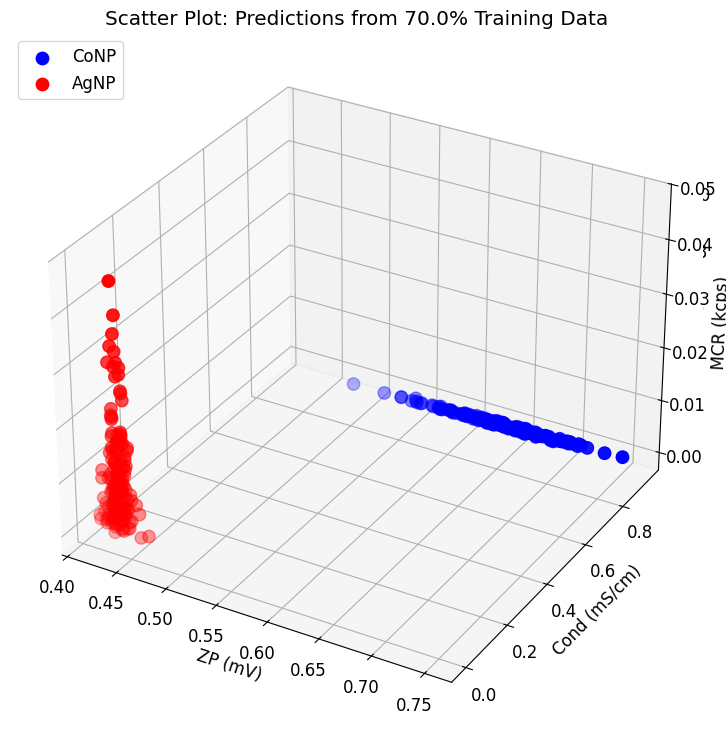

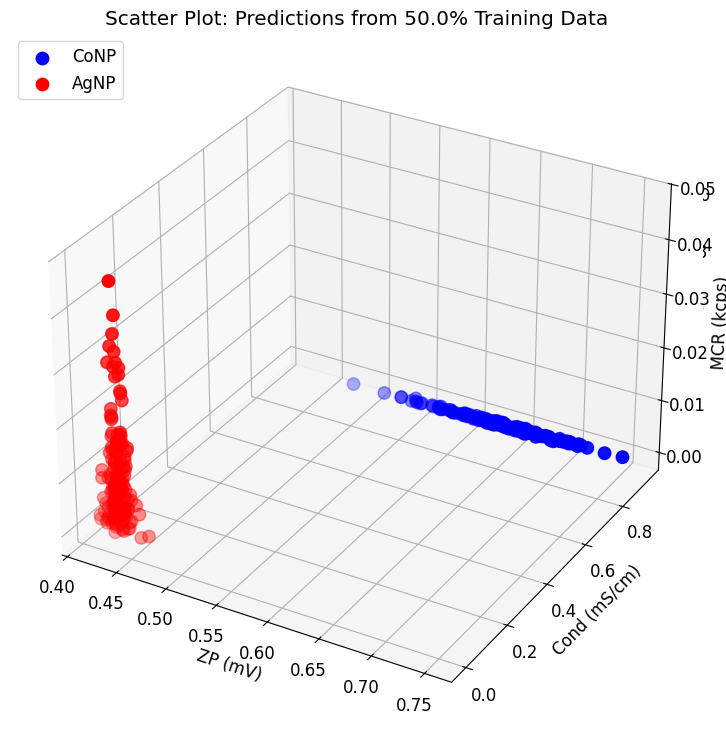

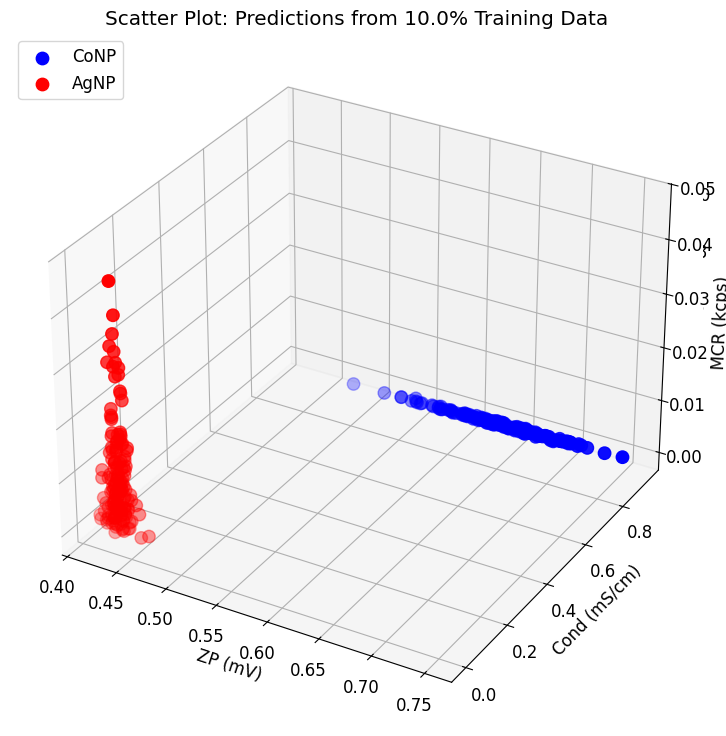

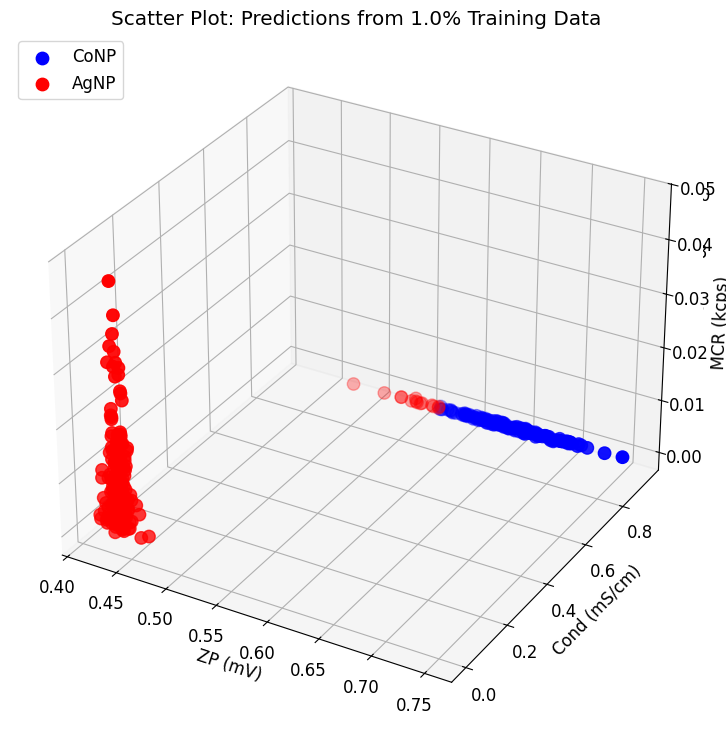

In [133]:
#=======================================3D Scatter Plot===============================
for i in range(len(train_set)):
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(1,1,1,projection='3d')
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(test_features[pred_vqtask1[i]==0,0], test_features[pred_vqtask1[i]==0,1], test_features[pred_vqtask1[i]==0,2], c='blue', marker='o', label='CoNP', s=80)
    ax.scatter(test_features[pred_vqtask1[i]==1,0], test_features[pred_vqtask1[i]==1,1], test_features[pred_vqtask1[i]==1,2], c='red', marker='o', label='AgNP',s=80)
  # Set labels for each axis
    ax.set_xlabel('ZP (mV)')
    ax.set_ylabel('Cond (mS/cm)')
    ax.set_zlabel('MCR (kcps)')
    ax.set_title(f'Scatter Plot: Predictions from {train_set[i]*100}% Training Data')
    ax.tick_params("z", which="major",length=15,width = 2.0)
    ax.legend(loc='upper left')
    plt.show()

### ROC Curve for Vector Quantum Classifier (CoNP vs AgNP)

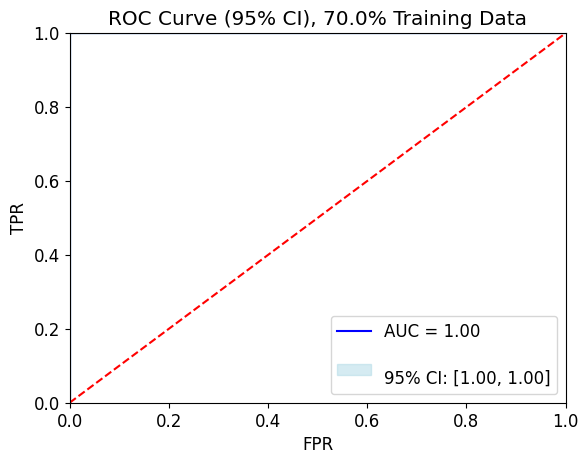

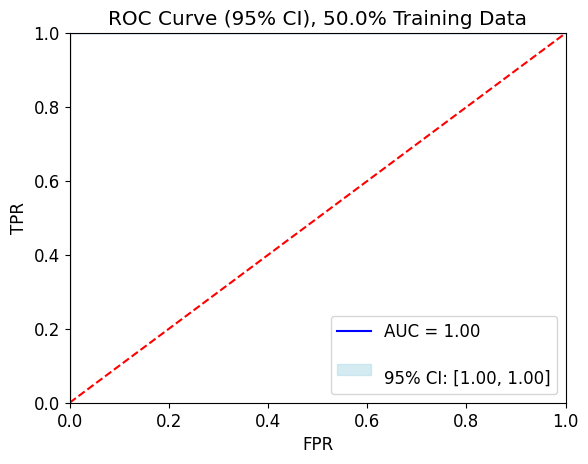

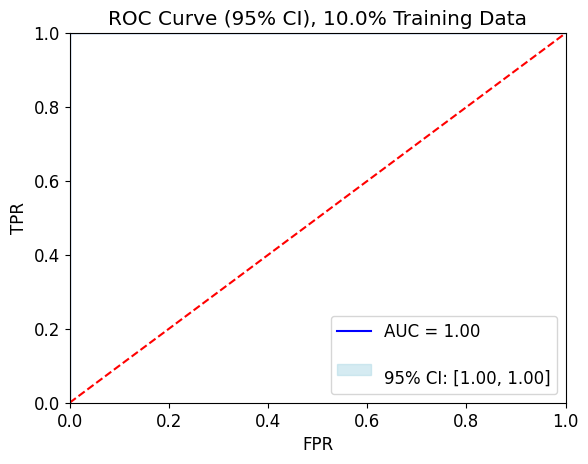

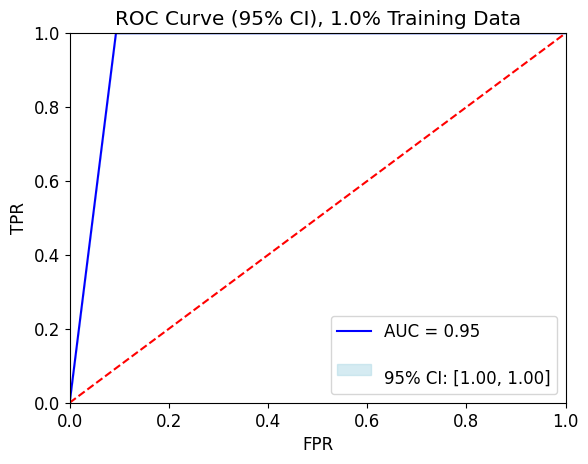

In [134]:
evaluate_ROC(train_set, test_labels, pred_vqtask1)

### Confusion Matrix for Vector Quantum Classifier (CoNP vs AgNP)

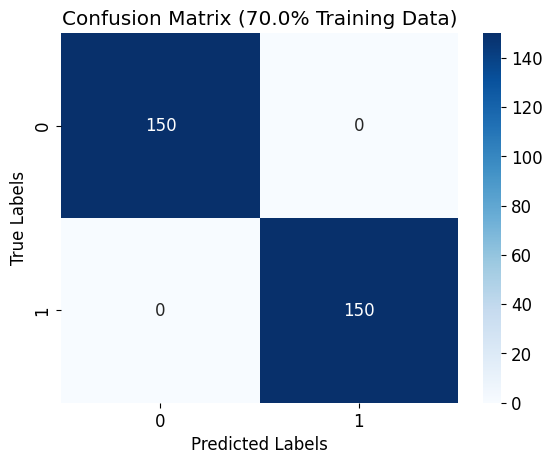

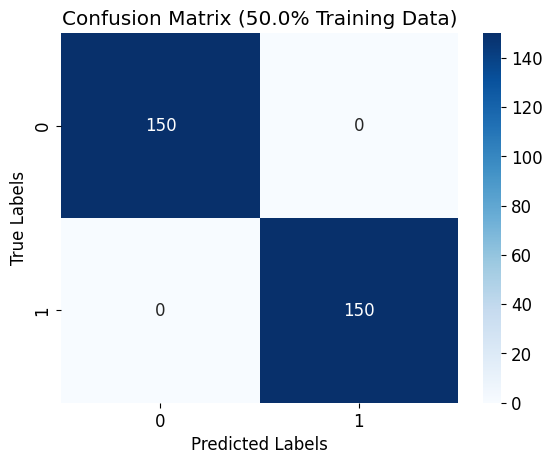

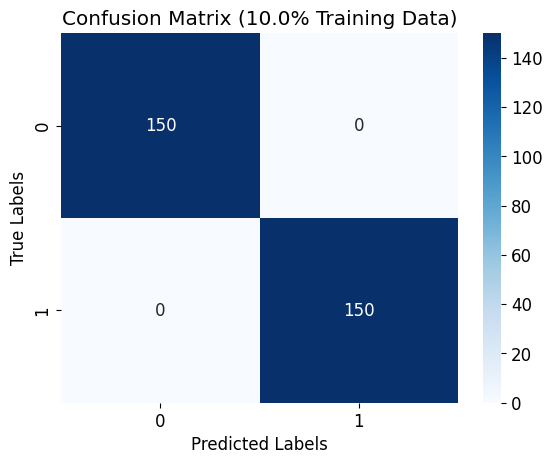

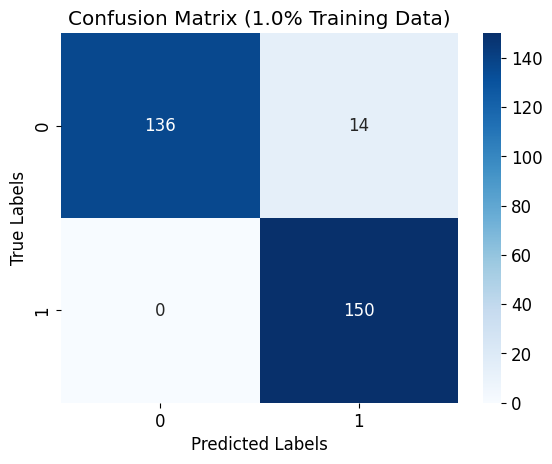

In [135]:
evaluate_con_mat(train_set, test_labels, pred_vqtask1)